# Setting up the GPU devices

In [1]:
import os
!echo "CUDA Path: $CUDA_HOME"

CUDA Path: /software/spackages_v0_21_prod/apps/linux-ubuntu22.04-cascadelake/gcc-13.2.0/cuda-11.8.0-bkg4vbnylxxujqrsdd43kut5wfqmvq6x


In [2]:
cuda_path = "/software/spackages_v0_21_prod/apps/linux-ubuntu22.04-cascadelake/gcc-13.2.0/cuda-11.8.0-bkg4vbnylxxujqrsdd43kut5wfqmvq6x"
os.environ['CUDA_HOME'] = cuda_path
os.environ['CUDA_ROOT'] = cuda_path
os.environ['CUDA_PATH'] = cuda_path
os.environ['LD_LIBRARY_PATH'] = f"{cuda_path}/lib64:" + os.environ.get('LD_LIBRARY_PATH', '')
os.environ['XLA_FLAGS'] = f'--xla_gpu_cuda_data_dir={cuda_path}'

#Verify CUDA installation (using Python, not shell variables)
print("Checking CUDA files:")
# Use Python to check the directory
import os
libdevice_path = os.path.join(cuda_path, "nvvm", "libdevice")
if os.path.exists(libdevice_path):
    print(f"Found libdevice directory: {libdevice_path}")
    print("Contents:", os.listdir(libdevice_path))
else:
    print(f"ERROR: Directory not found: {libdevice_path}")
    print("Try finding libdevice with:")
    print(f"!find {cuda_path} -name 'libdevice.10.bc' 2>/dev/null")

# Cell 3: Direct shell command (no Python variables)
print("\nDirect shell check:")
!ls /software/spackages_v0_21_prod/apps/linux-ubuntu22.04-cascadelake/gcc-13.2.0/cuda-11.8.0-bkg4vbnylxxujqrsdd43kut5wfqmvq6x

Checking CUDA files:
Found libdevice directory: /software/spackages_v0_21_prod/apps/linux-ubuntu22.04-cascadelake/gcc-13.2.0/cuda-11.8.0-bkg4vbnylxxujqrsdd43kut5wfqmvq6x/nvvm/libdevice
Contents: ['libdevice.10.bc']

Direct shell check:
bin		   gds	     nsight-compute-2022.3.0  pkgconfig  tools
compute-sanitizer  gds-11.8  nsightee_plugins	      README	 version.json
DOCS		   include   nsight-systems-2022.4.2  share
EULA.txt	   lib64     nvml		      src
extras		   libnvvp   nvvm		      targets


In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

print(f"🔧 CUDA Configuration:")
print(f"   CUDA_HOME: {os.environ.get('CUDA_HOME')}")
print(f"   XLA_FLAGS: {os.environ.get('XLA_FLAGS')}")

libdevice_path = os.path.join(cuda_path, "nvvm", "libdevice", "libdevice.10.bc")
if os.path.exists(libdevice_path):
    print(f"   ✅ Found libdevice: {libdevice_path}")
else:
    print(f"   ❌ ERROR: libdevice not found at {libdevice_path}")

🔧 CUDA Configuration:
   CUDA_HOME: /software/spackages_v0_21_prod/apps/linux-ubuntu22.04-cascadelake/gcc-13.2.0/cuda-11.8.0-bkg4vbnylxxujqrsdd43kut5wfqmvq6x
   XLA_FLAGS: --xla_gpu_cuda_data_dir=/software/spackages_v0_21_prod/apps/linux-ubuntu22.04-cascadelake/gcc-13.2.0/cuda-11.8.0-bkg4vbnylxxujqrsdd43kut5wfqmvq6x
   ✅ Found libdevice: /software/spackages_v0_21_prod/apps/linux-ubuntu22.04-cascadelake/gcc-13.2.0/cuda-11.8.0-bkg4vbnylxxujqrsdd43kut5wfqmvq6x/nvvm/libdevice/libdevice.10.bc


## Importing Essential Libraries

In [4]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import pandas as pd
import matplotlib
import random
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.plot import render_label
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

bioimageio_utils.py (2): pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
2025-07-10 15:56:32.868383: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 15:56:32.923139: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-10 15:56:32.923204: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-10 15:56:32.923238: E

In [5]:
import pims
import trackpy as tp

## Loading the Data

In [6]:
# To read the image data
my_fl_img= pims.open('../Image_Data/old/Top_30_Microns.tif')
my_fl_label = pims.open('../Image_Data/old/LblImg_Top_30_Microns.tif')

In [7]:
my_fl_img

<Frames>
Source: ../Image_Data/old/Top_30_Microns.tif
Length: 31 frames
Frame Shape: (2048, 2048)
Pixel Datatype: uint16

In [8]:
print(my_fl_img.shape)
print(my_fl_label.shape)

(31, 2048, 2048)
(31, 2048, 2048)


### Cropping the image for testing and easier visualisation

In [9]:
x_start, x_end = 1000, 1512  # Crop along X
y_start, y_end = 1000, 1512  # Crop along Y

In [10]:
cropped_frames = np.array([frame[y_start:y_end, x_start:x_end] for frame in my_fl_img])
cropped_labels = np.array([frame[y_start:y_end, x_start:x_end] for frame in my_fl_label])

In [11]:
print(f"Shape of the cropped image stack: {cropped_frames.shape}")
print(f"Shape of the cropped label stack: {cropped_labels.shape}")

Shape of the cropped image stack: (31, 512, 512)
Shape of the cropped label stack: (31, 512, 512)


In [12]:
cropped_frames = np.expand_dims(cropped_frames, axis=-1) 
cropped_labels = np.expand_dims(cropped_labels, axis=-1) 

In [13]:
print(f"Shape of the cropped image stack: {cropped_frames.shape}")

Shape of the cropped image stack: (31, 512, 512, 1)


## Loading Custom Trained stardist Model

In [14]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [15]:
from stardist.models import StarDist2D  # For 2D model

# Load with directory structure used during training
model = StarDist2D(None, name='stardist_trained_Top30Micron_500epoch_v0', basedir='../models/')

2025-07-10 15:57:01.341567: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-07-10 15:57:01.341984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9647 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.466292, nms_thresh=0.3.


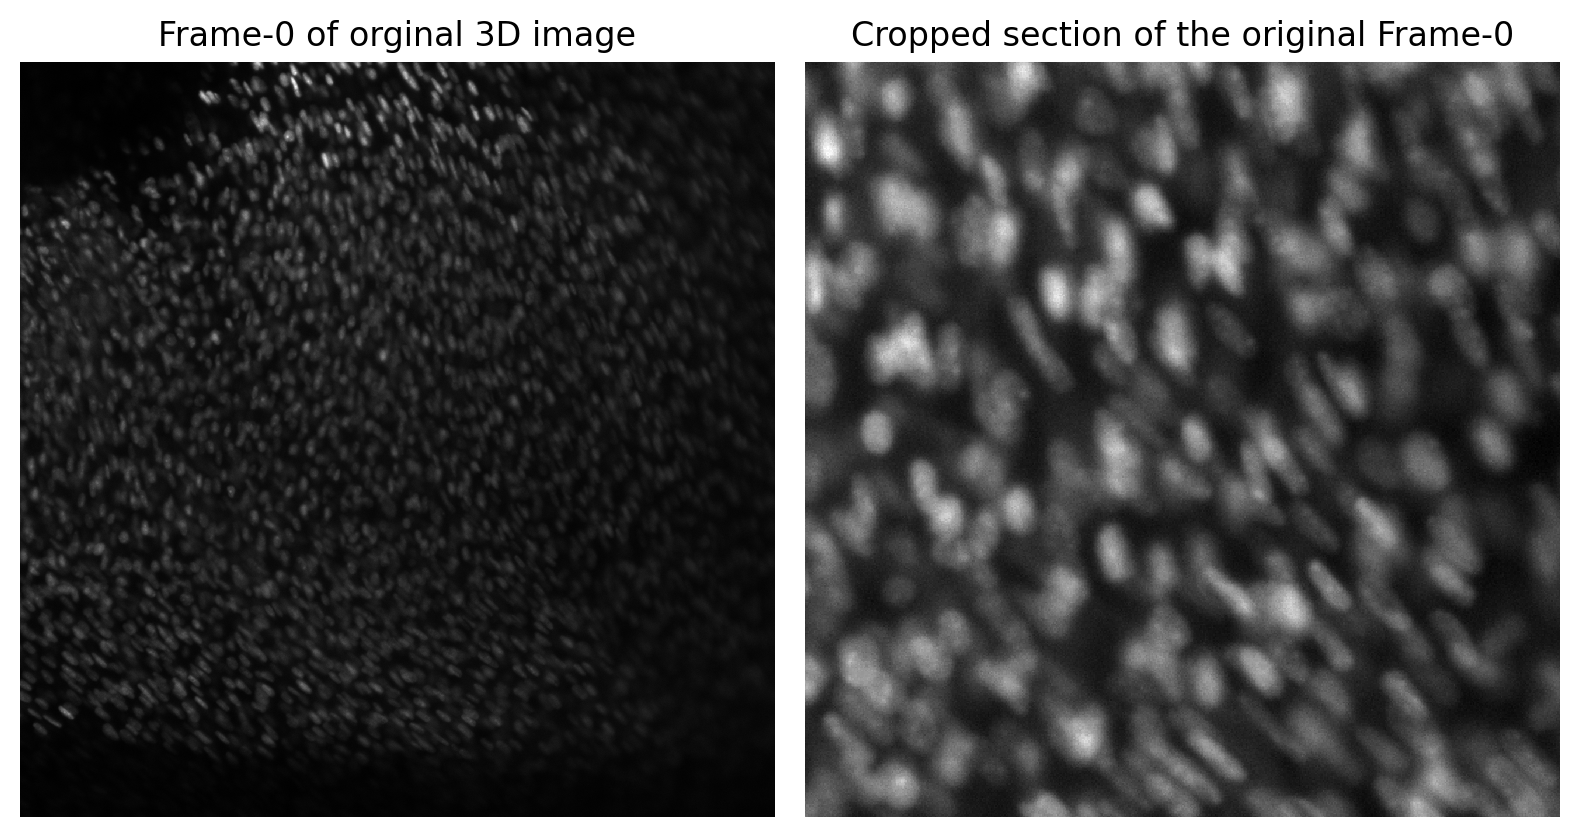

In [16]:
plt.figure(figsize=(8,8))

plt.subplot(121)
plt.imshow(my_fl_img[0], cmap='gray')
plt.title('Frame-0 of orginal 3D image')
plt.axis("off")

plt.subplot(122)
plt.imshow(cropped_frames[0], cmap='gray')
plt.title('Cropped section of the original Frame-0')
plt.axis("off")

# Show plot
plt.tight_layout()
plt.show()

TypeError: text() missing 1 required positional argument: 's'

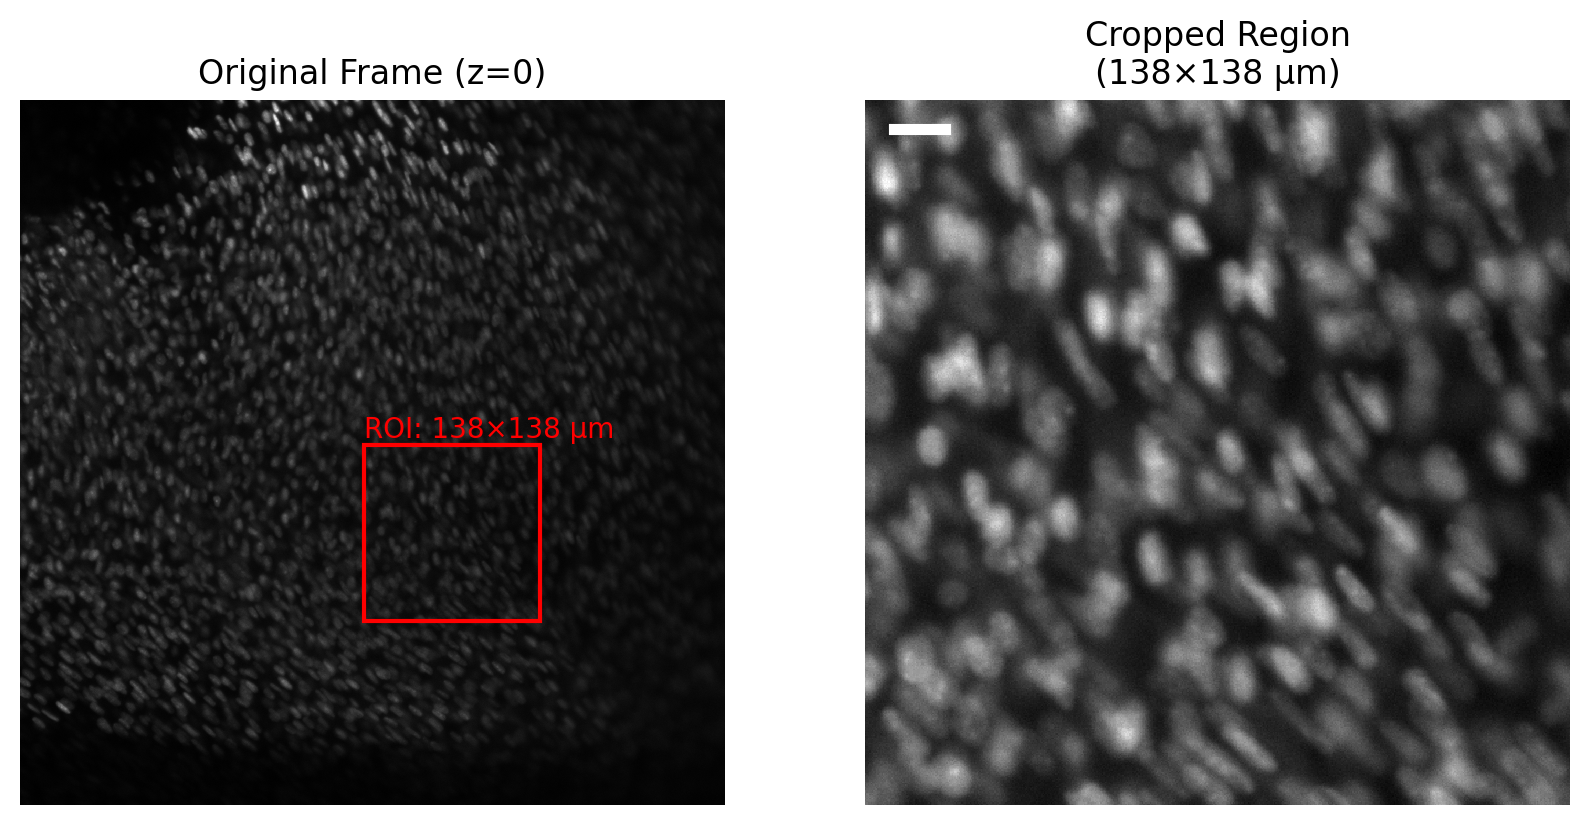

In [17]:
# Calculate micron dimensions
pixel_size_xy = 0.27  # micron per pixel
crop_width = (x_end - x_start) * pixel_size_xy
crop_height = (y_end - y_start) * pixel_size_xy

# Create figure
plt.figure(figsize=(10, 8))

# Original image with ROI highlight
plt.subplot(121)
plt.imshow(my_fl_img[0], cmap='gray')
plt.title('Original Frame (z=0)', fontsize=12)
plt.axis("off")

# Add rectangle showing cropped region
roi_rect = Rectangle((x_start, y_start), 
                     x_end - x_start, 
                     y_end - y_start,
                     fill=False, 
                     edgecolor='red', 
                     linewidth=1.5)
plt.gca().add_patch(roi_rect)
plt.text(x_start, y_start - 20, 
         f'ROI: {crop_width:.0f}×{crop_height:.0f} µm', 
         color='red', fontsize=10)

# Cropped section with scale bar
plt.subplot(122)
plt.imshow(cropped_frames[0], cmap='gray')
plt.title(f'Cropped Region\n({crop_width:.0f}×{crop_height:.0f} µm)', fontsize=12)
plt.axis("off")

# Create manual scale bar (10 microns)
bar_length_px = 10 / pixel_size_xy  # Length for 10 microns
bar_thickness = 4  # pixels
bar_margin = 20  # pixels from edge
bar_color = 'white'
text_color = 'white'
bg_color = 'black'

# Draw scale bar
plt.plot([bar_margin, bar_margin + bar_length_px], 
         [bar_margin, bar_margin], 
         color=bar_color, 
         linewidth=bar_thickness)

# Add scale text with background
plt.text(bar_margin + bar_length_px/2, 
         bar_margin + 15, 
         color=text_color, 
         ha='center', 
         va='bottom',
         fontsize=10,
         bbox=dict(facecolor=bg_color, 
                   alpha=0.7, 
                   boxstyle='round,pad=0.2',
                   edgecolor='none'))

# Add micron marker
plt.text(10, 20, "Scale: 10 µm", color=text_color, fontsize=9, 
         bbox=dict(facecolor=bg_color, alpha=0.7, pad=2))

# Add panel labels for publication
plt.figtext(0.05, 0.95, "A", weight="bold", fontsize=14)
plt.figtext(0.55, 0.95, "B", weight="bold", fontsize=14)

# Show plot
plt.tight_layout()
plt.show()

### Applying Stardist2D to all frames

In [18]:
@pims.pipeline
def stardist_segm(img):
  img_labels, img_details = model.predict_instances(normalize(img))
  return img_labels

In [19]:
import time
start_time = time.time()

label_image = stardist_segm(my_fl_img)

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

Time taken: 0.0001652240753173828 seconds


In [20]:
label_image

(TiffStack_tifffile,) processed through proc_func. Original repr:
    <Frames>
    Source: ../Image_Data/old/Top_30_Microns.tif
    Length: 31 frames
    Frame Shape: (2048, 2048)
    Pixel Datatype: uint16

2025-07-10 15:57:25.023746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


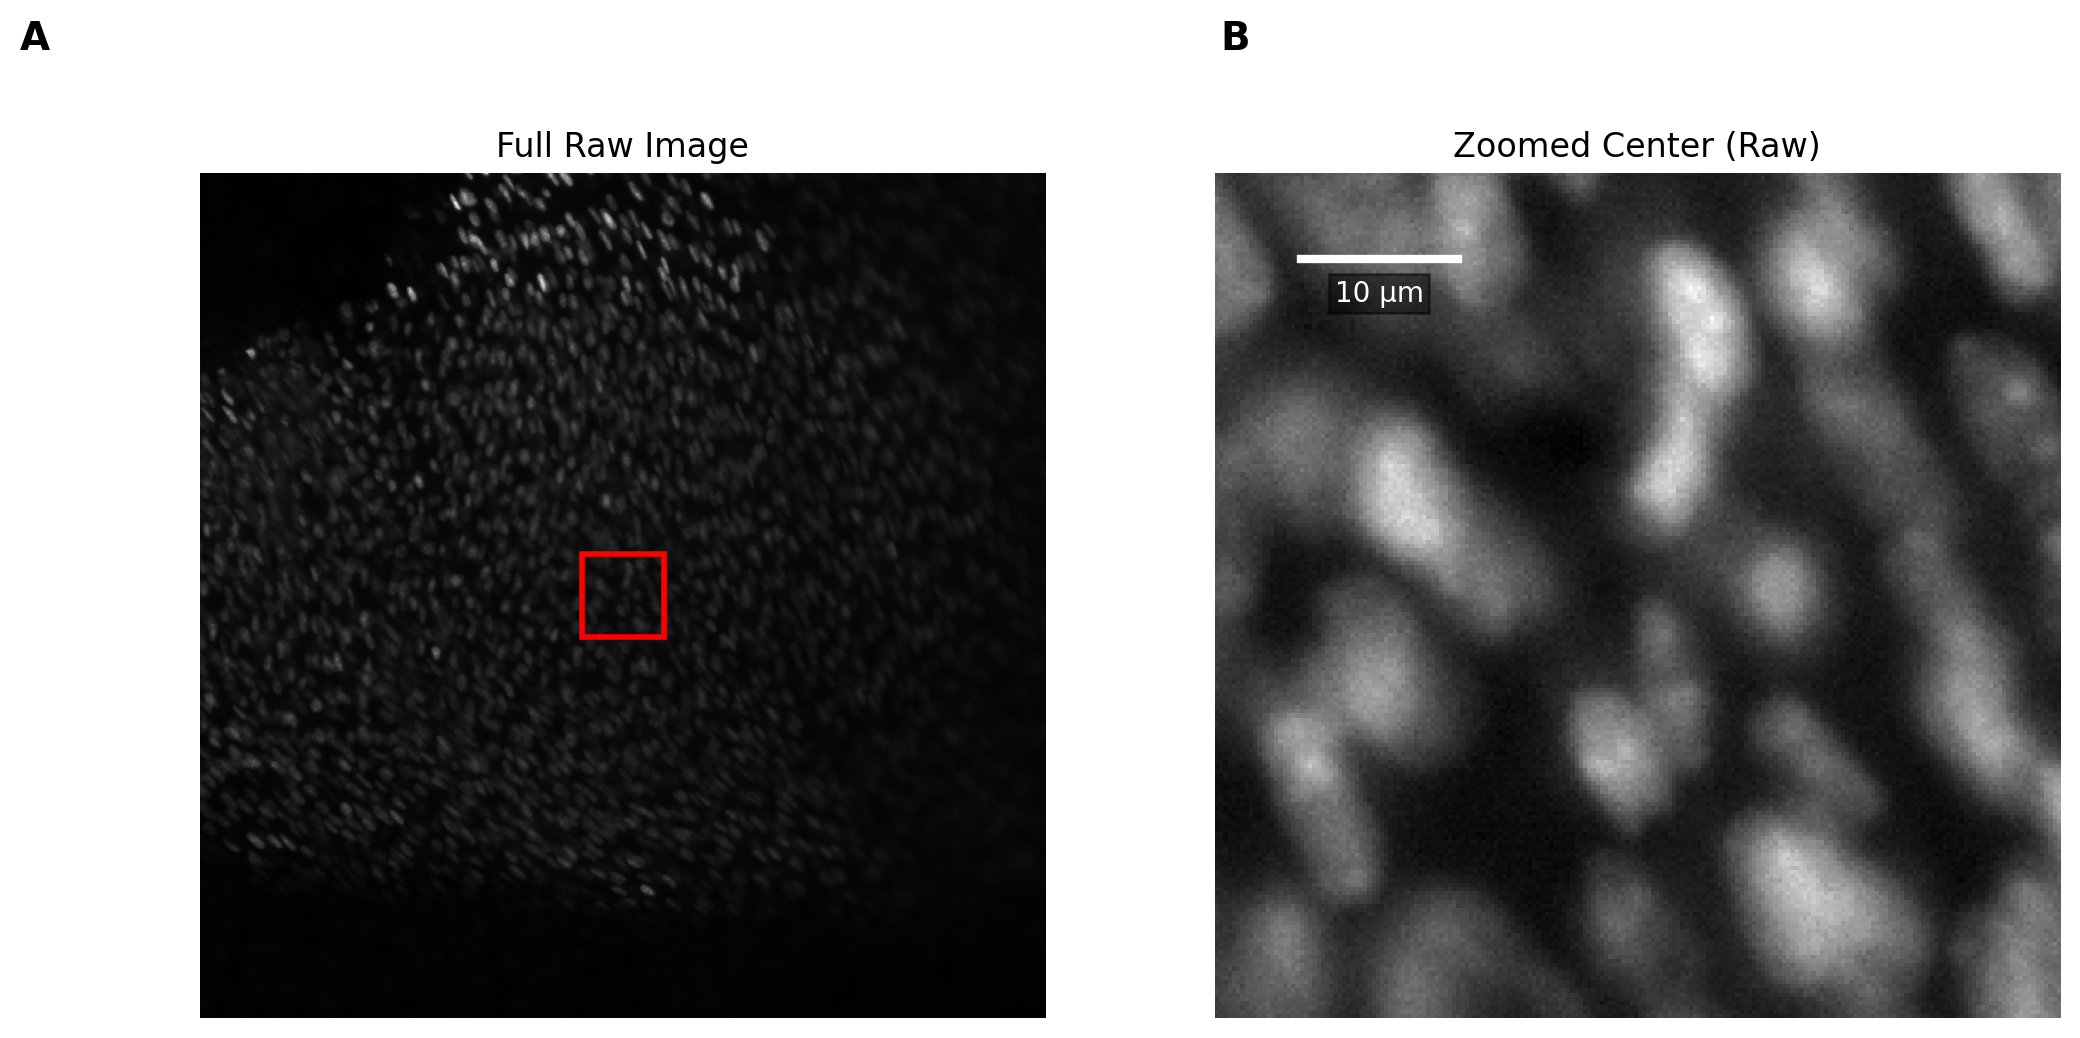

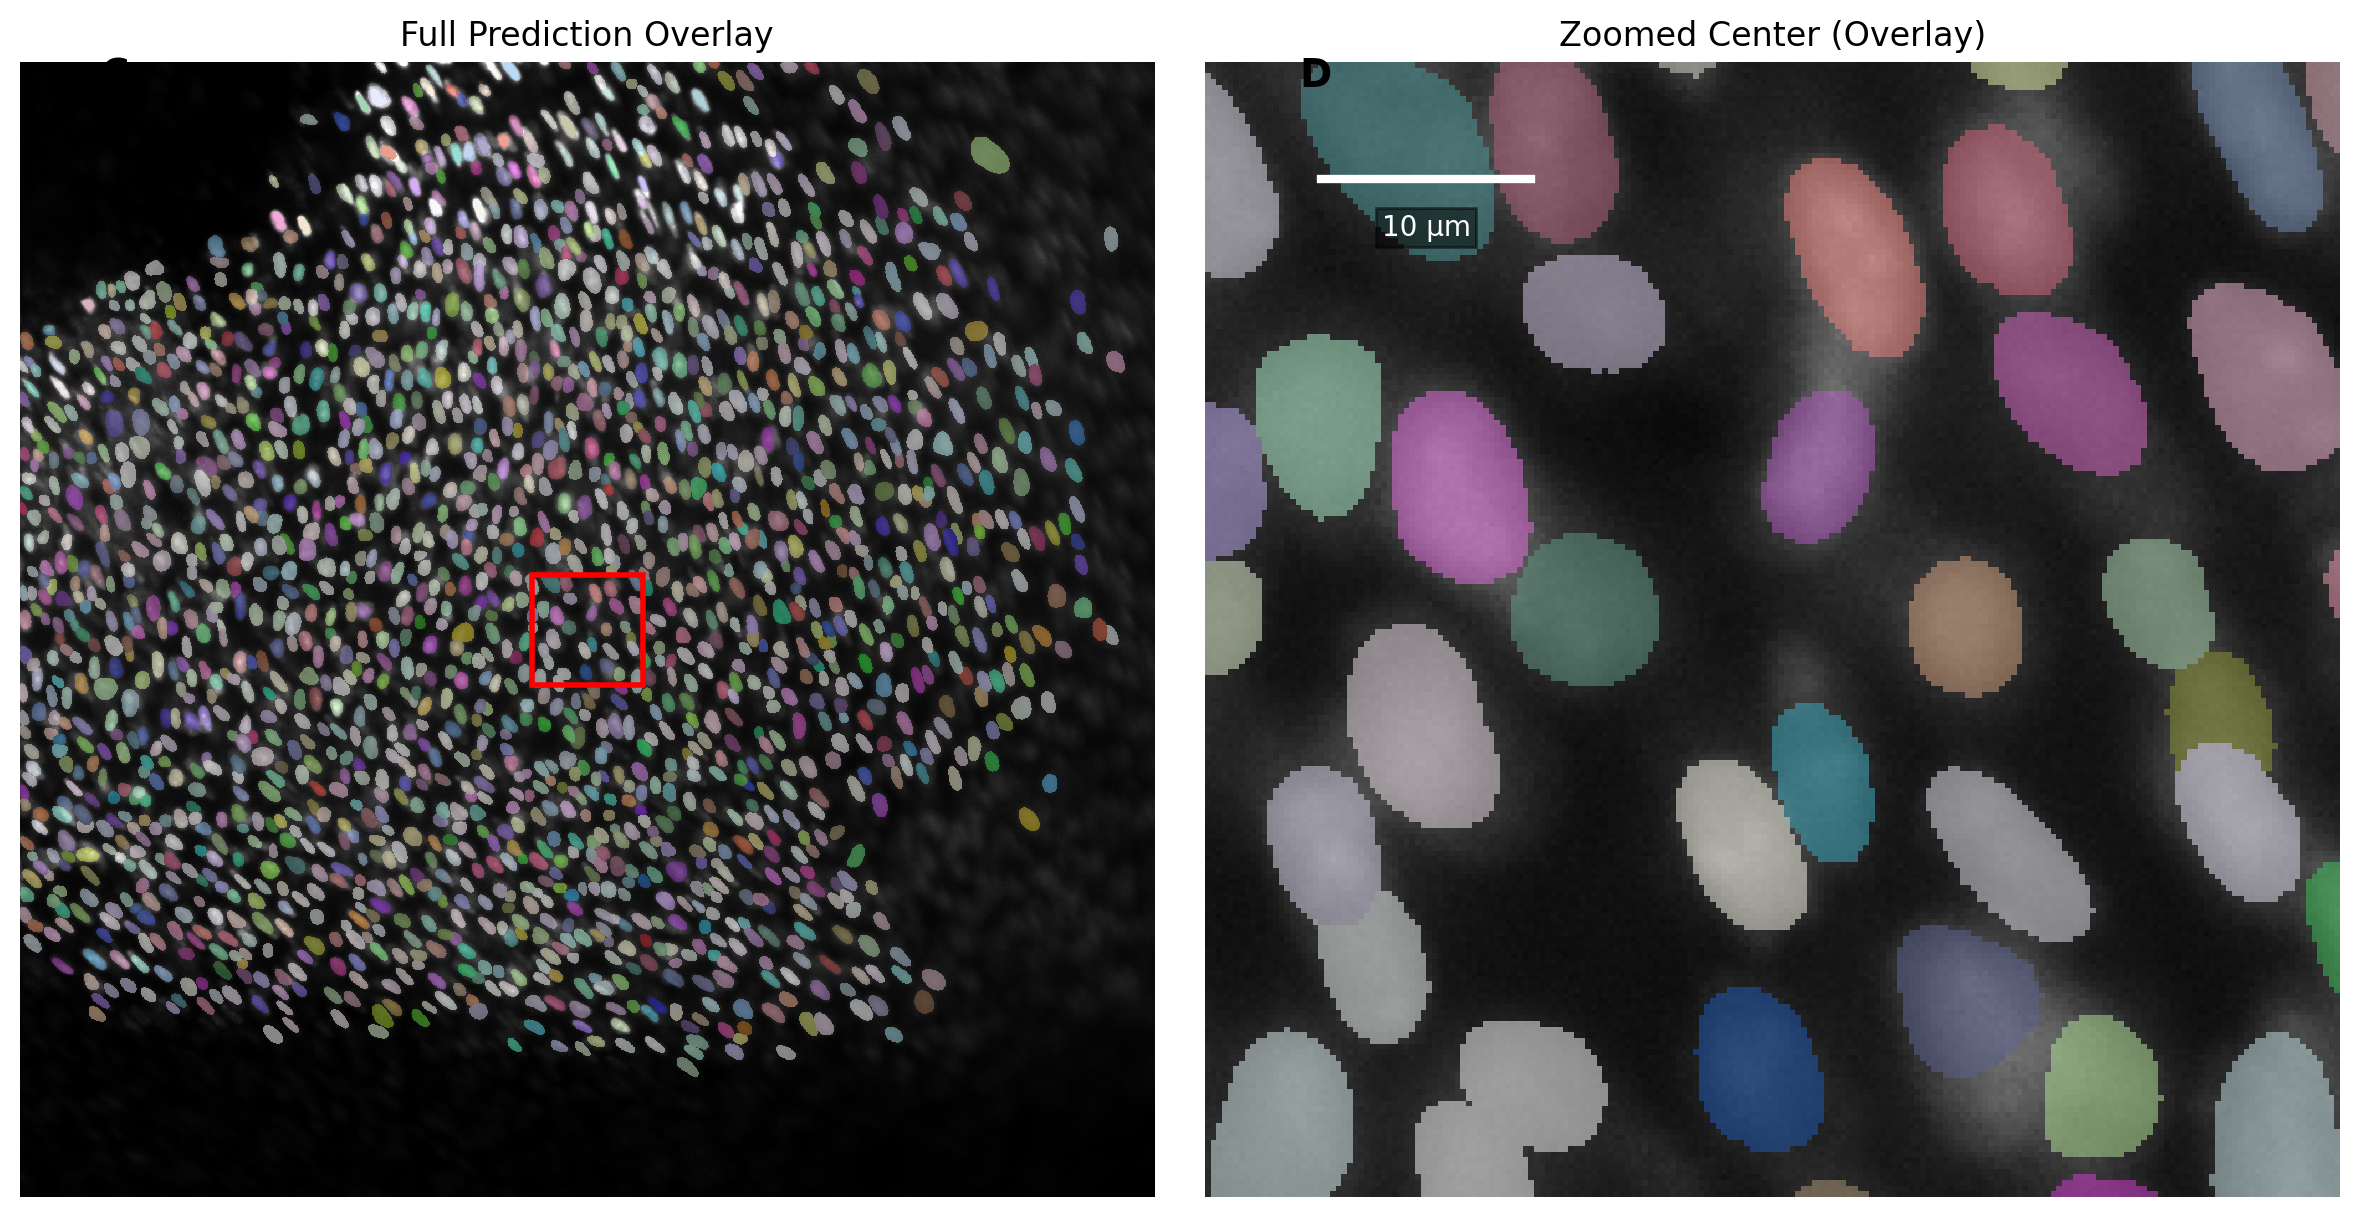

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Select slice and define crop parameters
img_num = 7
crop_size = 200  # Size of the zoomed-in region in pixels

# Get full images
raw_img = my_fl_img[img_num]
overlay_img = render_label(label_image[img_num], img=raw_img)

# Calculate center coordinates
height, width = raw_img.shape
center_x, center_y = width // 2, height // 2
crop_half = crop_size // 2

# Create crop boundaries
x_start = center_x - crop_half
x_end = center_x + crop_half
y_start = center_y - crop_half
y_end = center_y + crop_half

# Create figure
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original raw image with ROI highlight
ax[0].imshow(raw_img, cmap='gray')
ax[0].set_title('Full Raw Image', fontsize=12)
ax[0].axis("off")

# Add rectangle showing zoomed region
roi_rect = Rectangle((x_start, y_start), 
                     crop_size, 
                     crop_size,
                     fill=False, 
                     edgecolor='red', 
                     linewidth=2)
ax[0].add_patch(roi_rect)

# Zoomed raw image
cropped_raw = raw_img[y_start:y_end, x_start:x_end]
ax[1].imshow(cropped_raw, cmap='gray')
ax[1].set_title('Zoomed Center (Raw)', fontsize=12)
ax[1].axis("off")

# Add scale bar to zoomed image (10 microns)
pixel_size = 0.27  # micron per pixel
scale_length = int(10 / pixel_size)  # 10 micron bar in pixels
ax[1].plot([20, 20 + scale_length], 
           [20, 20], 
           color='white', 
           linewidth=3)
ax[1].text(20 + scale_length/2, 30, "10 µm", 
           color='white', ha='center', fontsize=10,
           bbox=dict(facecolor='black', alpha=0.5, pad=2))

# Create second figure for overlay comparison
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 6))

# Original overlay
ax2[0].imshow(overlay_img)
ax2[0].set_title('Full Prediction Overlay', fontsize=12)
ax2[0].axis("off")

# Add rectangle showing zoomed region
roi_rect2 = Rectangle((x_start, y_start), 
                      crop_size, 
                      crop_size,
                      fill=False, 
                      edgecolor='red', 
                      linewidth=2)
ax2[0].add_patch(roi_rect2)

# Zoomed overlay
cropped_overlay = overlay_img[y_start:y_end, x_start:x_end]
ax2[1].imshow(cropped_overlay)
ax2[1].set_title('Zoomed Center (Overlay)', fontsize=12)
ax2[1].axis("off")

# Add scale bar
ax2[1].plot([20, 20 + scale_length], 
            [20, 20], 
            color='white', 
            linewidth=3)
ax2[1].text(20 + scale_length/2, 30, "10 µm", 
            color='white', ha='center', fontsize=10,
            bbox=dict(facecolor='black', alpha=0.5, pad=2))

# Add panel labels
for i, fig in enumerate([fig, fig2]):
    fig.text(0.05, 0.95, "A" if i == 0 else "C", weight="bold", fontsize=14)
    fig.text(0.55, 0.95, "B" if i == 0 else "D", weight="bold", fontsize=14)

plt.tight_layout()
plt.show()

### Extracting morphological features from the segmented frames

In [22]:
import skimage
from skimage import measure
import time

In [23]:
import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf

In [24]:
regions = measure.regionprops(label_image[0], intensity_image=my_fl_img[0])

# Print available attributes for the first region in the list
print(dir(regions[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cache', '_cache_active', '_extra_properties', '_image_intensity_double', '_intensity_image', '_label_image', '_multichannel', '_ndim', '_offset', '_pixel_area', '_slice', '_spacing', '_spatial_axes', 'area', 'area_bbox', 'area_convex', 'area_filled', 'axis_major_length', 'axis_minor_length', 'bbox', 'centroid', 'centroid_local', 'centroid_weighted', 'centroid_weighted_local', 'coords', 'coords_scaled', 'eccentricity', 'equivalent_diameter_area', 'euler_number', 'extent', 'feret_diameter_max', 'image', 'image_convex', 'image_filled', 'image_intensity', 'inertia_tensor', 'inertia_tensor_eig

In [25]:
# Initialize the list to store the features
features = []

start_time = time.time()

# Iterate over the frames in the image stack
for num, img in enumerate(my_fl_img):
    # For each labeled region (nucleus) in the current frame
    for region in measure.regionprops(label_image[num], intensity_image=img):
        # Append each dictionary to the features list with additional features
        features.append({
            'y': region.centroid[0],  # Y coordinate of the centroid
            'x': region.centroid[1],  # X coordinate of the centroid
            'frame': num,  # The current frame number
            'area': region.area,  # Area of the nucleus
            'eccentricity': region.eccentricity,  # Eccentricity of the nucleus
            'solidity': region.solidity,  # Solidity of the nucleus
            'axis_major_length': region.axis_major_length,  # Length of the major axis
            'axis_minor_length': region.axis_minor_length,  # Length of the minor axis
            'feret_diameter_max': region.feret_diameter_max,  # Maximum Feret's diameter
            'perimeter': region.perimeter,  # Perimeter of the nucleus
            'intensity_max': region.intensity_max,  # Maximum intensity within the nucleus
            'intensity_mean': region.intensity_mean,  # Mean intensity within the nucleus
            'intensity_min': region.intensity_min,  # Minimum intensity within the nucleus
            'intensity_std': region.intensity_std,  # Standard deviation of intensity
            'orientation': region.orientation,  # Orientation of the nucleus
            'euler_number': region.euler_number,  # Euler number of the nucleus
            'bbox': region.bbox  # Bounding box coordinates (min_row, min_col, max_row, max_col)
        })

# Convert list to DataFrame
features_df = pd.DataFrame(features)

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

# Display the first few rows
print(features_df.head())

Time taken: 149.9522614479065 seconds
             y            x  frame   area  eccentricity  solidity  \
0   763.471292   285.008373      0  836.0      0.755845  0.973225   
1   965.274119  1277.860643      0  653.0      0.851887  0.964549   
2  1654.557760  1270.457410      0  857.0      0.821836  0.960762   
3   554.071429  1566.030612      0  784.0      0.871759  0.966708   
4   931.084605  1161.104022      0  721.0      0.799501  0.966488   

   axis_major_length  axis_minor_length  feret_diameter_max   perimeter  \
0          40.350787          26.419701           40.607881  109.254834   
1          39.883778          20.888188           40.024992   99.840620   
2          43.918008          25.021138           44.407207  115.639610   
3          45.221939          22.155804           45.310043  112.325902   
4          39.188939          23.539394           38.832976  103.012193   

   intensity_max  intensity_mean  intensity_min  intensity_std  orientation  \
0         3736.0 

In [26]:
features_df['area_sq_micron'] = features_df['area'] * 0.27 * 0.27
features_df.head()

y            x  frame   area  eccentricity  solidity  \
0   763.471292   285.008373      0  836.0      0.755845  0.973225   
1   965.274119  1277.860643      0  653.0      0.851887  0.964549   
2  1654.557760  1270.457410      0  857.0      0.821836  0.960762   
3   554.071429  1566.030612      0  784.0      0.871759  0.966708   
4   931.084605  1161.104022      0  721.0      0.799501  0.966488   

   axis_major_length  axis_minor_length  feret_diameter_max   perimeter  \
0          40.350787          26.419701           40.607881  109.254834   
1          39.883778          20.888188           40.024992   99.840620   
2          43.918008          25.021138           44.407207  115.639610   
3          45.221939          22.155804           45.310043  112.325902   
4          39.188939          23.539394           38.832976  103.012193   

   intensity_max  intensity_mean  intensity_min  intensity_std  orientation  \
0         3736.0     2525.008373         1318.0     579.560837     0.056759   
1         2980.0     2236.886677         1458.0     310.301488     0.145704   
2         3121.0     2099.975496         1193.0     451.455781     0.880976   
3         3075.0     2180.487245         1572.0     285.985215     0.344918   
4         3020.0     2230.391123         1507.0     379.729508     0.027698   

   euler_number                      bbox  area_sq_micron  
0             1      (744, 272, 784, 298)         60.9444  
1             1    (946, 1267, 985, 1289)         47.6037  
2             1  (1637, 1252, 1672, 1290)         62.4753  
3             1    (534, 1553, 576, 1580)         57.1536  
4             1    (913, 1150, 951, 1173)         52.5609

1544799090.py (16): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
1544799090.py (17): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


x     4.620290
y    15.819149
dtype: float64
x    342.400955
y    346.733570
dtype: float64


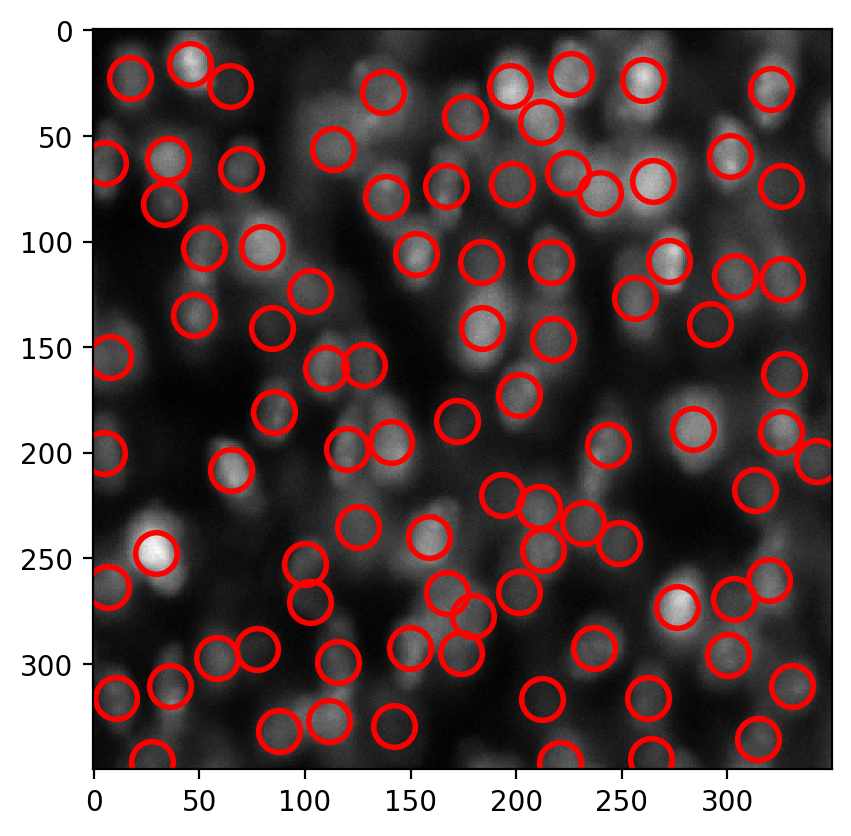

<Axes: >

In [27]:
# Define the cropping range for rows and columns
x_start, x_end = 500, 850  # Horizontal crop range
y_start, y_end = 500, 850  # Vertical crop range

# Crop the image (e.g., from the 0th frame)
cropped_image = my_fl_img[0][y_start:y_end, x_start:x_end]

# Adjust the features' coordinates based on the cropping
cropped_features = features_df.loc[
    (features_df['x'] >= x_start) & (features_df['x'] < x_end) & 
    (features_df['y'] >= y_start) & (features_df['y'] < y_end) & 
    (features_df['frame'] == 0)  # Only the current frame
]

# Adjust the feature coordinates relative to the cropped image region
cropped_features['x'] = cropped_features['x'] - x_start
cropped_features['y'] = cropped_features['y'] - y_start

print(cropped_features[['x', 'y']].min())
print(cropped_features[['x', 'y']].max())

# Visualize the cropped features on the cropped image
tp.annotate(cropped_features, cropped_image)


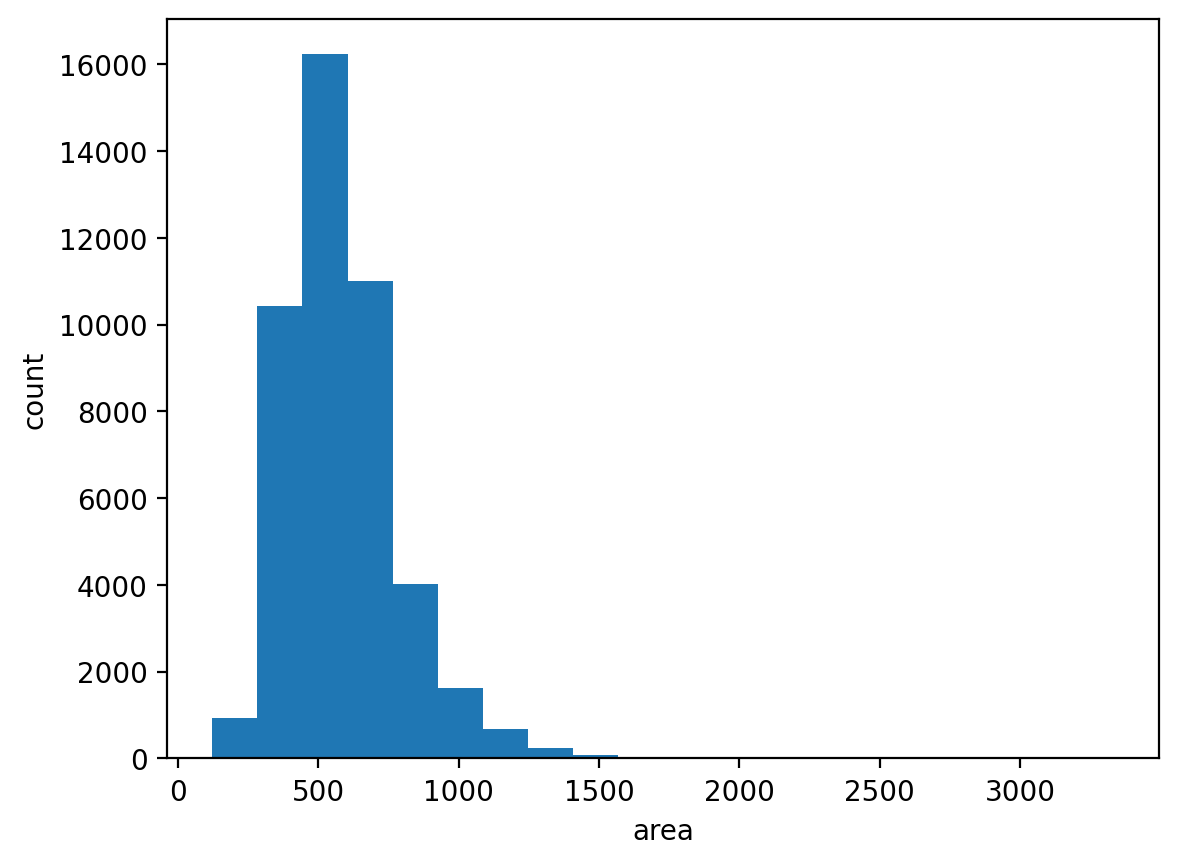

In [28]:
#Plot object areas to investigate the distribution. You can further filter out objects based on size or intensity. Not required in our case.  
fig, ax = plt.subplots()
ax.hist(features_df['area'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='area', ylabel='count');

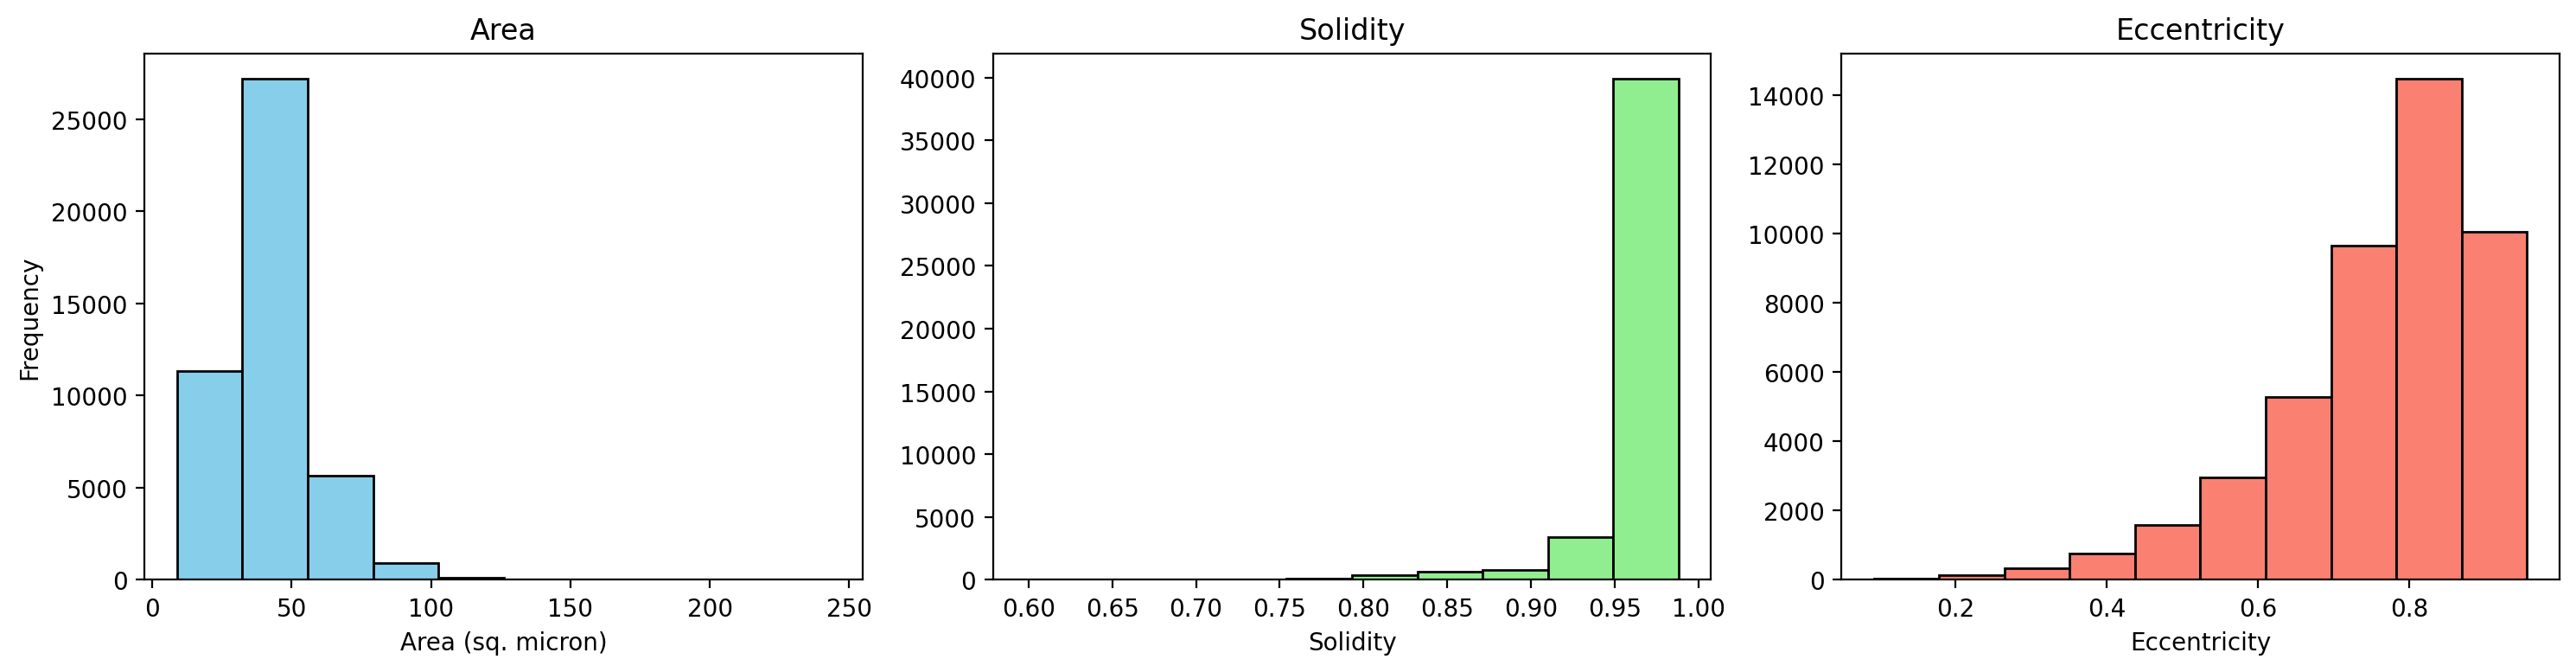

In [29]:
# Plot histograms in one row
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# Histogram for area
axes[0].hist(features_df['area_sq_micron'], bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Area')
axes[0].set_xlabel('Area (sq. micron)')
axes[0].set_ylabel('Frequency')

# Histogram for solidity
axes[1].hist(features_df['solidity'], bins=10, color='lightgreen', edgecolor='black')
axes[1].set_title('Solidity')
axes[1].set_xlabel('Solidity')

# Histogram for eccentricity
axes[2].hist(features_df['eccentricity'], bins=10, color='salmon', edgecolor='black')
axes[2].set_title('Eccentricity')
axes[2].set_xlabel('Eccentricity')

plt.tight_layout()
plt.show()

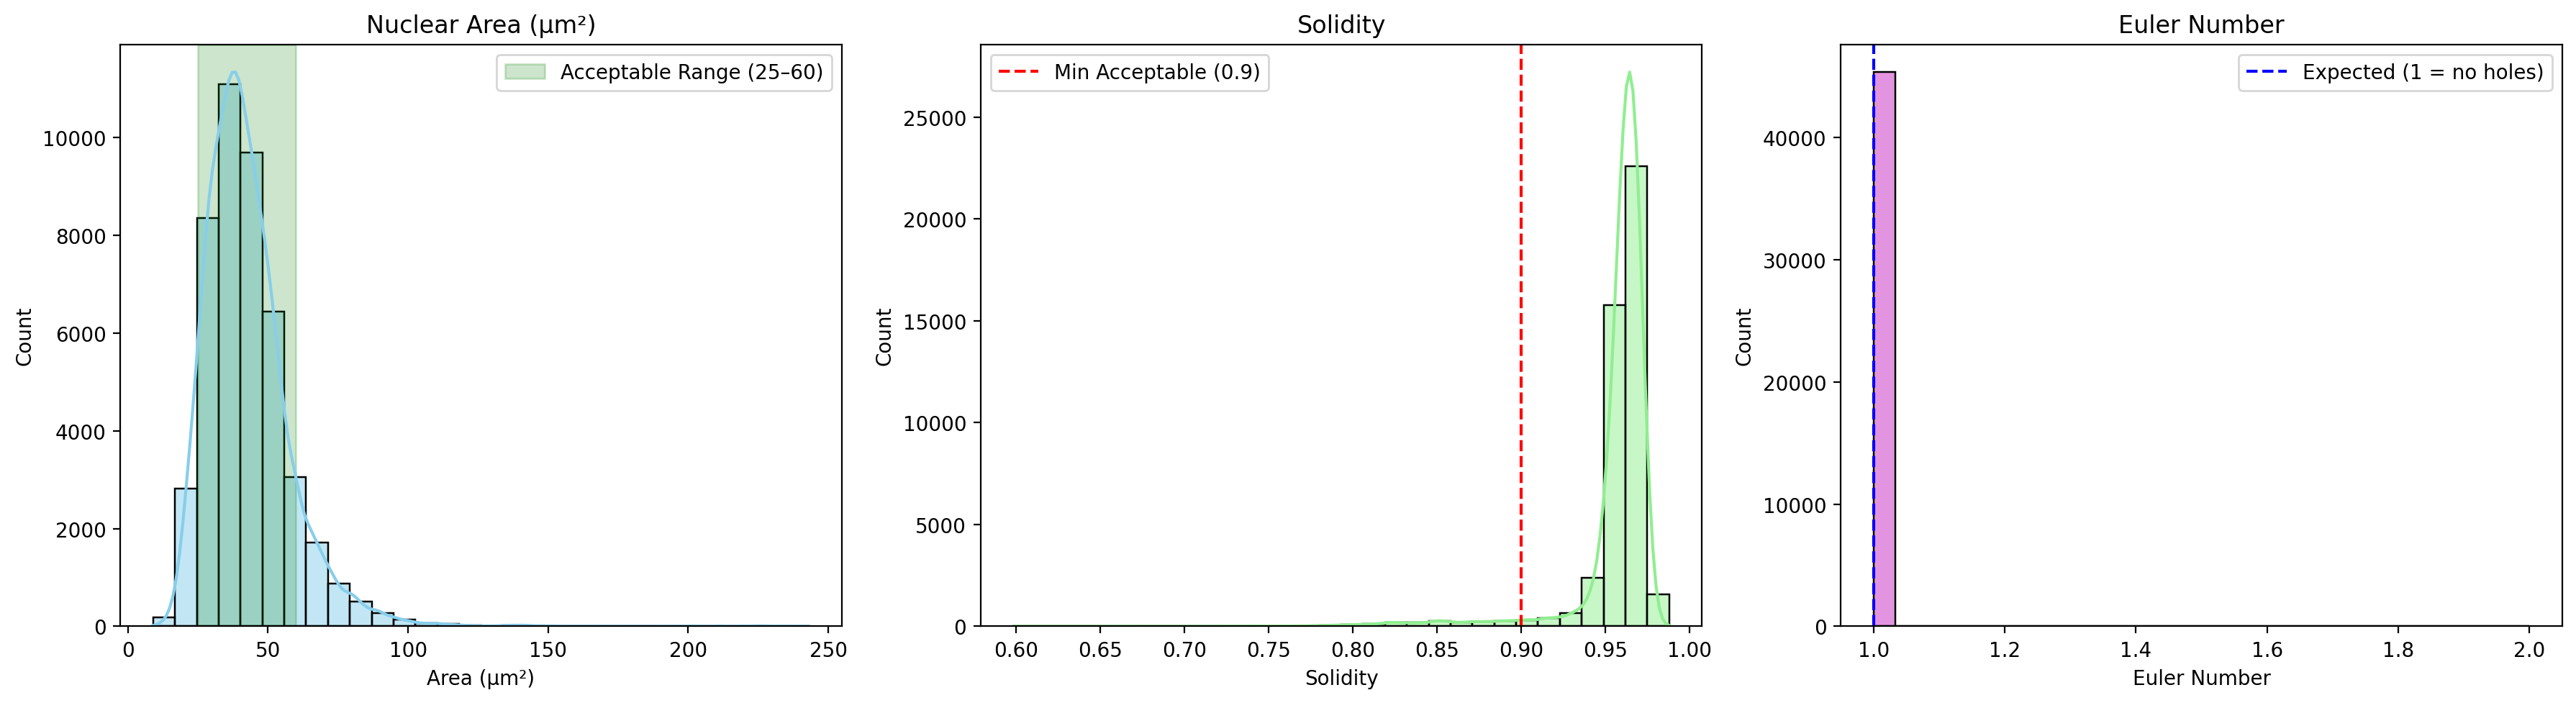

In [36]:
import seaborn as sns

# Set up the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
bins = 30  # higher resolution histograms

# --- Area plot ---
sns.histplot(features_df['area_sq_micron'], bins=bins, kde=True, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Nuclear Area (μm²)')
axes[0].set_xlabel('Area (μm²)')
axes[0].axvspan(25, 60, color='green', alpha=0.2, label='Acceptable Range (25–60)')
axes[0].legend()

# --- Solidity plot ---
sns.histplot(features_df['solidity'], bins=bins, kde=True, ax=axes[1], color='lightgreen', edgecolor='black')
axes[1].set_title('Solidity')
axes[1].set_xlabel('Solidity')
axes[1].axvline(0.9, color='red', linestyle='--', label='Min Acceptable (0.9)')
axes[1].legend()

# --- Euler Number plot ---
sns.histplot(features_df['euler_number'], bins=bins, kde=False, ax=axes[2], color='orchid', edgecolor='black')
axes[2].set_title('Euler Number')
axes[2].set_xlabel('Euler Number')
axes[2].axvline(1, color='blue', linestyle='--', label='Expected (1 = no holes)')
axes[2].legend()

plt.tight_layout()
plt.show()

# Identifying and Visualsing abnormally shaped nuclei

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Helper to extract the right frame + crop
def extract_crop_multiframe(row, image_stack, margin=10):
    frame_idx = int(row['frame'])
    bbox = row['bbox']  # already a tuple
    ymin, xmin, ymax, xmax = bbox

    # Add margin but keep within image bounds
    frame = image_stack[frame_idx]
    height, width = frame.shape

    ymin = max(0, ymin - margin)
    xmin = max(0, xmin - margin)
    ymax = min(height, ymax + margin)
    xmax = min(width, xmax + margin)

    crop = frame[ymin:ymax, xmin:xmax]
    return crop, row['solidity'], row['euler_number'], frame_idx

# Define filters
normal_filter = (features_df['solidity'] >= 0.9) & (features_df['euler_number'] == 1)
solidity_fail_filter = features_df['solidity'] < 0.9
euler_fail_filter = features_df['euler_number'] != 1

# Get one example per category
normal_row = features_df[normal_filter].iloc[0]
solidity_row = features_df[solidity_fail_filter].iloc[0]
euler_row = features_df[euler_fail_filter].iloc[0]

# Extract crops from respective frames
normal_crop, s1, e1, f1 = extract_crop_multiframe(normal_row, my_fl_img)
solidity_crop, s2, e2, f2 = extract_crop_multiframe(solidity_row, my_fl_img)
euler_crop, s3, e3, f3 = extract_crop_multiframe(euler_row, my_fl_img)

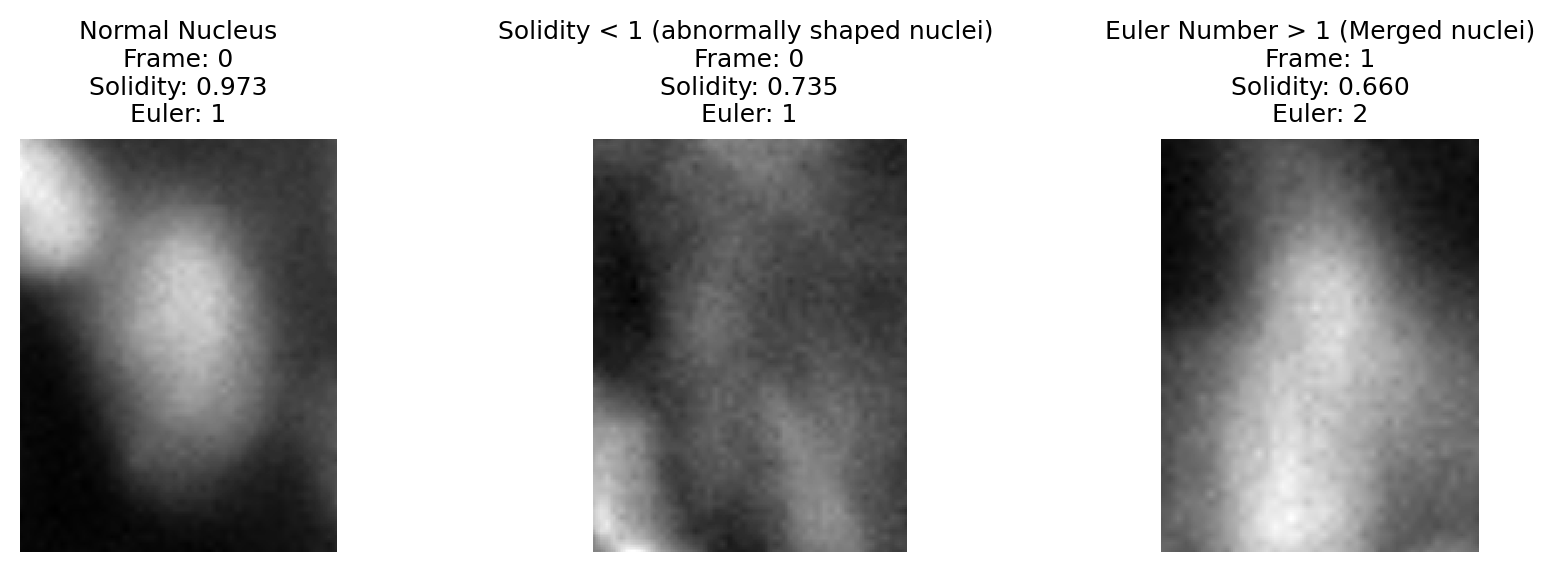

In [50]:
from scipy.ndimage import zoom

def upscale_crop(crop, scale=4):
    return zoom(crop, zoom=scale, order=1)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

plot_crop(axs[0], upscale_crop(normal_crop), "Normal Nucleus", s1, e1, f1)
plot_crop(axs[1], upscale_crop(solidity_crop), "Solidity < 1 (abnormally shaped nuclei) ", s2, e2, f2)
plot_crop(axs[2], upscale_crop(euler_crop), "Euler Number > 1 (Merged nuclei)", s3, e3, f3)

plt.tight_layout()
plt.show()

In [52]:
total_nuclei = len(features_df)

normal = features_df[(features_df['solidity'] >= 0.90) & (features_df['euler_number'] == 1)]
normal_perc = len(normal) / total_nuclei * 100

irregular = features_df[features_df['solidity'] < 0.90]
irregular_perc = len(irregular) / total_nuclei * 100

topological_defect = features_df[features_df['euler_number'] != 1]
topological_defect_perc = len(topological_defect) / total_nuclei * 100

mean_solidity = features_df['solidity'].mean()
std_solidity = features_df['solidity'].std()
mean_euler = features_df['euler_number'].mean()
std_euler = features_df['euler_number'].std()

print(f"Total nuclei: {total_nuclei}")
print(f"Normal nuclei: {len(normal)} ({normal_perc:.2f}%)")
print(f"Contour irregularity (solidity < 0.95): {len(irregular)} ({irregular_perc:.2f}%)")
print(f"Topological defects (Euler number != 1): {len(topological_defect)} ({topological_defect_perc:.2f}%)")
print(f"Mean solidity: {mean_solidity:.3f} ± {std_solidity:.3f}")
print(f"Mean Euler number: {mean_euler:.3f} ± {std_euler:.3f}")

Total nuclei: 45335
Normal nuclei: 43611 (96.20%)
Contour irregularity (solidity < 0.95): 1724 (3.80%)
Topological defects (Euler number != 1): 6 (0.01%)
Mean solidity: 0.957 ± 0.025
Mean Euler number: 1.000 ± 0.012


## Tracking nuclei spots across frames for 3D reconstruction

In [47]:
search_range = 11
t = tp.link_df(features_df, search_range, memory=1)
t.head()

Frame 30: 614 trajectories present.


y            x  frame   area  eccentricity  solidity  \
0      763.471292   285.008373      0  836.0      0.755845  0.973225   
1526  1504.036364  1490.647727      0  440.0      0.513887  0.971302   
1525  1271.678161   959.820690      0  435.0      0.595742  0.958150   
1524   846.230769   527.707692      0  585.0      0.488347  0.973378   
1523  1206.294931  1490.624424      0  434.0      0.848902  0.962306   

      axis_major_length  axis_minor_length  feret_diameter_max   perimeter  \
0             40.350787          26.419701           40.607881  109.254834   
1526          25.617329          21.976028           26.925824   76.284271   
1525          26.494168          21.279475           27.784888   79.355339   
1524          29.271213          25.543511           30.083218   88.183766   
1523          32.353011          17.100218           32.695565   81.355339   

      intensity_max  intensity_mean  intensity_min  intensity_std  \
0            3736.0     2525.008373         1318.0     579.560837   
1526         2397.0     1972.870455         1623.0     147.849736   
1525         2303.0     1845.062069         1303.0     186.161352   
1524         2630.0     2008.909402         1369.0     265.085944   
1523         1381.0     1132.725806          834.0     101.198081   

      orientation  euler_number                      bbox  particle  
0        0.056759             1      (744, 272, 784, 298)         0  
1526     1.024480             1  (1494, 1479, 1516, 1503)         1  
1525     0.331413             1    (1259, 950, 1284, 971)         2  
1524     0.047786             1      (832, 515, 861, 540)         3  
1523     0.381910             1  (1192, 1481, 1222, 1501)         4

In [48]:
# Checking the number of unique particles
t['particle'].nunique()

3288

In [49]:
linked_df = tp.link_df(features_df, 
                       search_range=3,     # Very small range since nuclei aren't moving
                       memory=0,           # No missing detections
                       neighbor_strategy='KDTree', 
                       link_strategy='recursive', 
                       pos_columns=['x', 'y'], 
                       t_column='frame')

Frame 30: 614 trajectories present.


In [50]:
# Checking the number of unique particles
linked_df['particle'].nunique()

6312

In [51]:
linked_df.head()

y            x  frame   area  eccentricity  solidity  \
0      763.471292   285.008373      0  836.0      0.755845  0.973225   
1526  1504.036364  1490.647727      0  440.0      0.513887  0.971302   
1525  1271.678161   959.820690      0  435.0      0.595742  0.958150   
1524   846.230769   527.707692      0  585.0      0.488347  0.973378   
1523  1206.294931  1490.624424      0  434.0      0.848902  0.962306   

      axis_major_length  axis_minor_length  feret_diameter_max   perimeter  \
0             40.350787          26.419701           40.607881  109.254834   
1526          25.617329          21.976028           26.925824   76.284271   
1525          26.494168          21.279475           27.784888   79.355339   
1524          29.271213          25.543511           30.083218   88.183766   
1523          32.353011          17.100218           32.695565   81.355339   

      intensity_max  intensity_mean  intensity_min  intensity_std  \
0            3736.0     2525.008373         1318.0     579.560837   
1526         2397.0     1972.870455         1623.0     147.849736   
1525         2303.0     1845.062069         1303.0     186.161352   
1524         2630.0     2008.909402         1369.0     265.085944   
1523         1381.0     1132.725806          834.0     101.198081   

      orientation  euler_number                      bbox  particle  
0        0.056759             1      (744, 272, 784, 298)         0  
1526     1.024480             1  (1494, 1479, 1516, 1503)         1  
1525     0.331413             1    (1259, 950, 1284, 971)         2  
1524     0.047786             1      (832, 515, 861, 540)         3  
1523     0.381910             1  (1192, 1481, 1222, 1501)         4

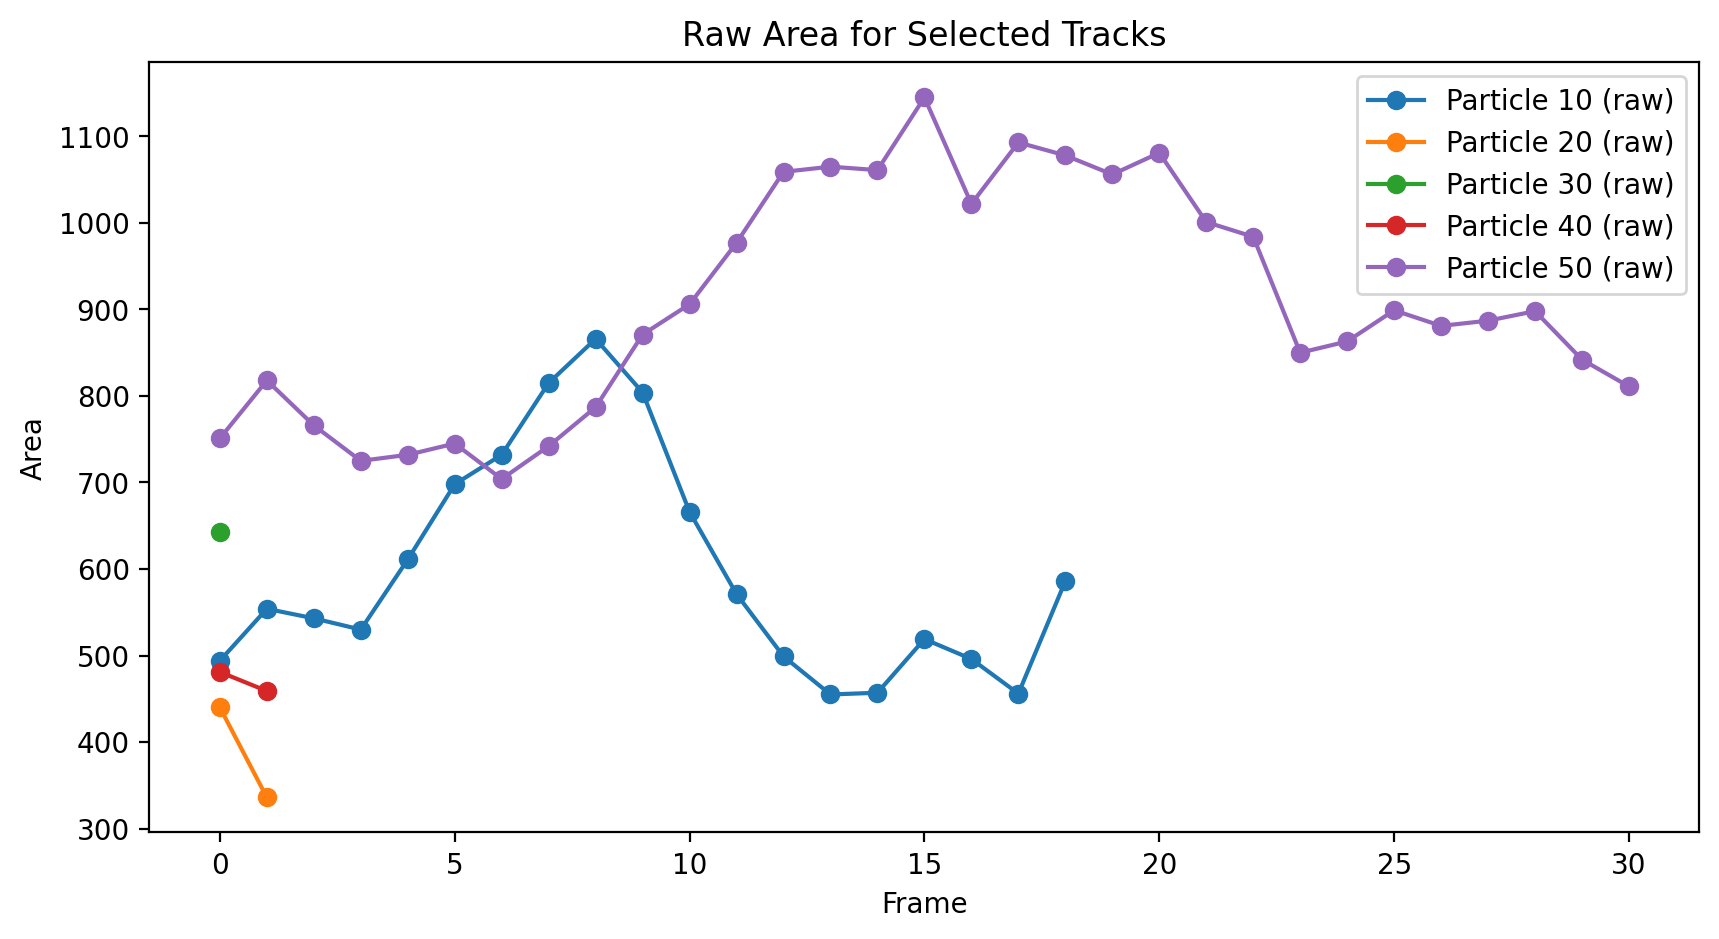

In [52]:
import matplotlib.pyplot as plt

# Pick a few tracks (let's say particle IDs 1, 2, and 3)
example_tracks = linked_df[linked_df['particle'].isin([10, 20, 30, 40, 50])]

# Plot raw area
plt.figure(figsize=(10, 5))
for pid in example_tracks['particle'].unique():
    subset = example_tracks[example_tracks['particle'] == pid]
    plt.plot(subset['frame'], subset['area'], marker='o', label=f'Particle {pid} (raw)')

plt.xlabel('Frame')
plt.ylabel('Area')
plt.legend()
plt.title('Raw Area for Selected Tracks')
plt.show()


The area for a particular particle (nuclei) should ideally exhibit a bell-shaped (Gaussian) trend when tracked across frames. However, that doesn't seem to be the case. It seems like mutiple nuclei are getting tracked as a single particle due very close vicinity. 

<b>Possible Causes:</b>

1. Crowding Effect: Nuclei are densely packed, leading to overlapping tracks.
2. Incorrect Linking Parameters: The search range and other linking parameters in TrackPy might not be optimized for the dataset.
3. Segmentation Errors: StarDist may be incorrectly identifying nuclei boundaries, leading to merged particles.

## Tracking Attempt II

In [31]:
linked_df['smoothed_area'] = linked_df.groupby('particle')['area'].transform(lambda x: x.rolling(window=5, center=True).mean())

In [ ]:
linked_df['relative_mass'] = linked_df['area'] / linked_df['smoothed_area']
filtered_df = linked_df[linked_df['relative_mass'].between(0.5, 1.5)]

In [55]:
# Size-based filtering parameters (pre-tracking)
min_area = 300    # pixels² (conservative lower bound)
max_area = 900    # pixels²
min_major = 30    # pixels
max_major = 60    # pixels
min_minor = 10    # pixels
max_minor = 20    # pixels
min_ecc = 0.65    # eccentricity

# Applying size/shape filter BEFORE tracking
filtered_df = features_df[
    (features_df['area'] >= min_area) &
    (features_df['area'] <= max_area) &
    (features_df['axis_major_length'] >= min_major) &
    (features_df['axis_major_length'] <= max_major) &
    (features_df['axis_minor_length'] >= min_minor) &
    (features_df['axis_minor_length'] <= max_minor) &
    (features_df['eccentricity'] >= min_ecc)
]

In [56]:
filtered_df.shape

(13087, 17)

In [59]:
# Create new columns with weighted values
filtered_df['x_weighted'] = filtered_df['x'] * 1.0
filtered_df['y_weighted'] = filtered_df['y'] * 1.0
filtered_df['area_weighted'] = filtered_df['area'] * 0.3

# Use the new weighted columns in linking
linked_df = tp.link_df(
    filtered_df,
    search_range=2.5,
    memory=1,
    neighbor_strategy='KDTree',
    link_strategy='nonrecursive',
    pos_columns=['x_weighted', 'y_weighted', 'area_weighted'],  # Plain column names
    t_column='frame',
    predictor=None,
    adaptive_stop=0.2
)

Frame 30: 166 trajectories present.


In [61]:
def validate_cardiac_tracks(df):
    valid_tracks = []
    
    for particle_id, track in df.groupby('particle'):
        n_frames = len(track)
        
        # 1. Frame span check (3-6 frames)
        if not (3 <= n_frames <= 6):
            continue
            
        # 2. Position stability check
        centroid = track[['x', 'y']].mean().values
        distances = np.sqrt((track['x'] - centroid[0])**2 + 
                            (track['y'] - centroid[1])**2)
        max_drift = distances.max()
        
        # 3. Area profile check (Gaussian-like)
        z = track['frame'].values
        area = track['area'].values
        area_var = np.var(area)
        
        if area_var == 0:
            # Constant area - accept if within size range
            area_ok = (min_area <= area[0] <= max_area)
        else:
            # Quadratic fit for bell curve
            try:
                coeffs = np.polyfit(z, area, 2)
                pred_area = np.polyval(coeffs, z)
                ss_res = np.sum((area - pred_area)**2)
                ss_tot = np.sum((area - np.mean(area))**2)
                r2 = 1 - (ss_res / ss_tot)
                area_ok = (r2 > 0.7)
            except:
                # Fallback: check if max is in middle 50%
                max_idx = np.argmax(area)
                mid_start = int(n_frames * 0.25)
                mid_end = int(n_frames * 0.75)
                area_ok = (mid_start <= max_idx <= mid_end)
        
        # 4. Final validation
        if (max_drift < 2) and area_ok:
            track = track.copy()
            track['valid'] = True
            valid_tracks.append(track)
    
    return pd.concat(valid_tracks) if valid_tracks else pd.DataFrame()

In [63]:
import matplotlib.pyplot as plt

def plot_track_diagnostics(particle_id, df=linked_df):
    track = df[df['particle'] == particle_id]
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    
    # Positional stability
    ax[0,0].plot(track['frame'], track['x'], 'bo-', label='X Position')
    ax[0,0].plot(track['frame'], track['y'], 'ro-', label='Y Position')
    ax[0,0].set_title(f'Position Stability (Track {particle_id})')
    ax[0,0].set_ylabel('Position (pixels)')
    ax[0,0].legend()
    
    # Area profile
    ax[0,1].plot(track['frame'], track['area'], 'go-')
    ax[0,1].set_title('Area Profile')
    ax[0,1].set_ylabel('Area (pixels)')
    
    # Morphological features
    ax[1,0].plot(track['frame'], track['solidity'], 'mo-', label='Solidity')
    ax[1,0].plot(track['frame'], track['eccentricity'], 'co-', label='Eccentricity')
    ax[1,0].set_title('Morphological Stability')
    ax[1,0].set_ylabel('Feature Value')
    ax[1,0].legend()
    
    # Intensity profile
    ax[1,1].plot(track['frame'], track['intensity_mean'], 'yo-')
    ax[1,1].set_title('Intensity Profile')
    ax[1,1].set_ylabel('Mean Intensity')
    
    plt.tight_layout()
    plt.show()

# Plot good and bad tracks for comparison
#plot_track_diagnostics(12)   # Good track
#plot_track_diagnostics(47)   # Problem track

Found 616 valid tracks
10963 nuclei rejected


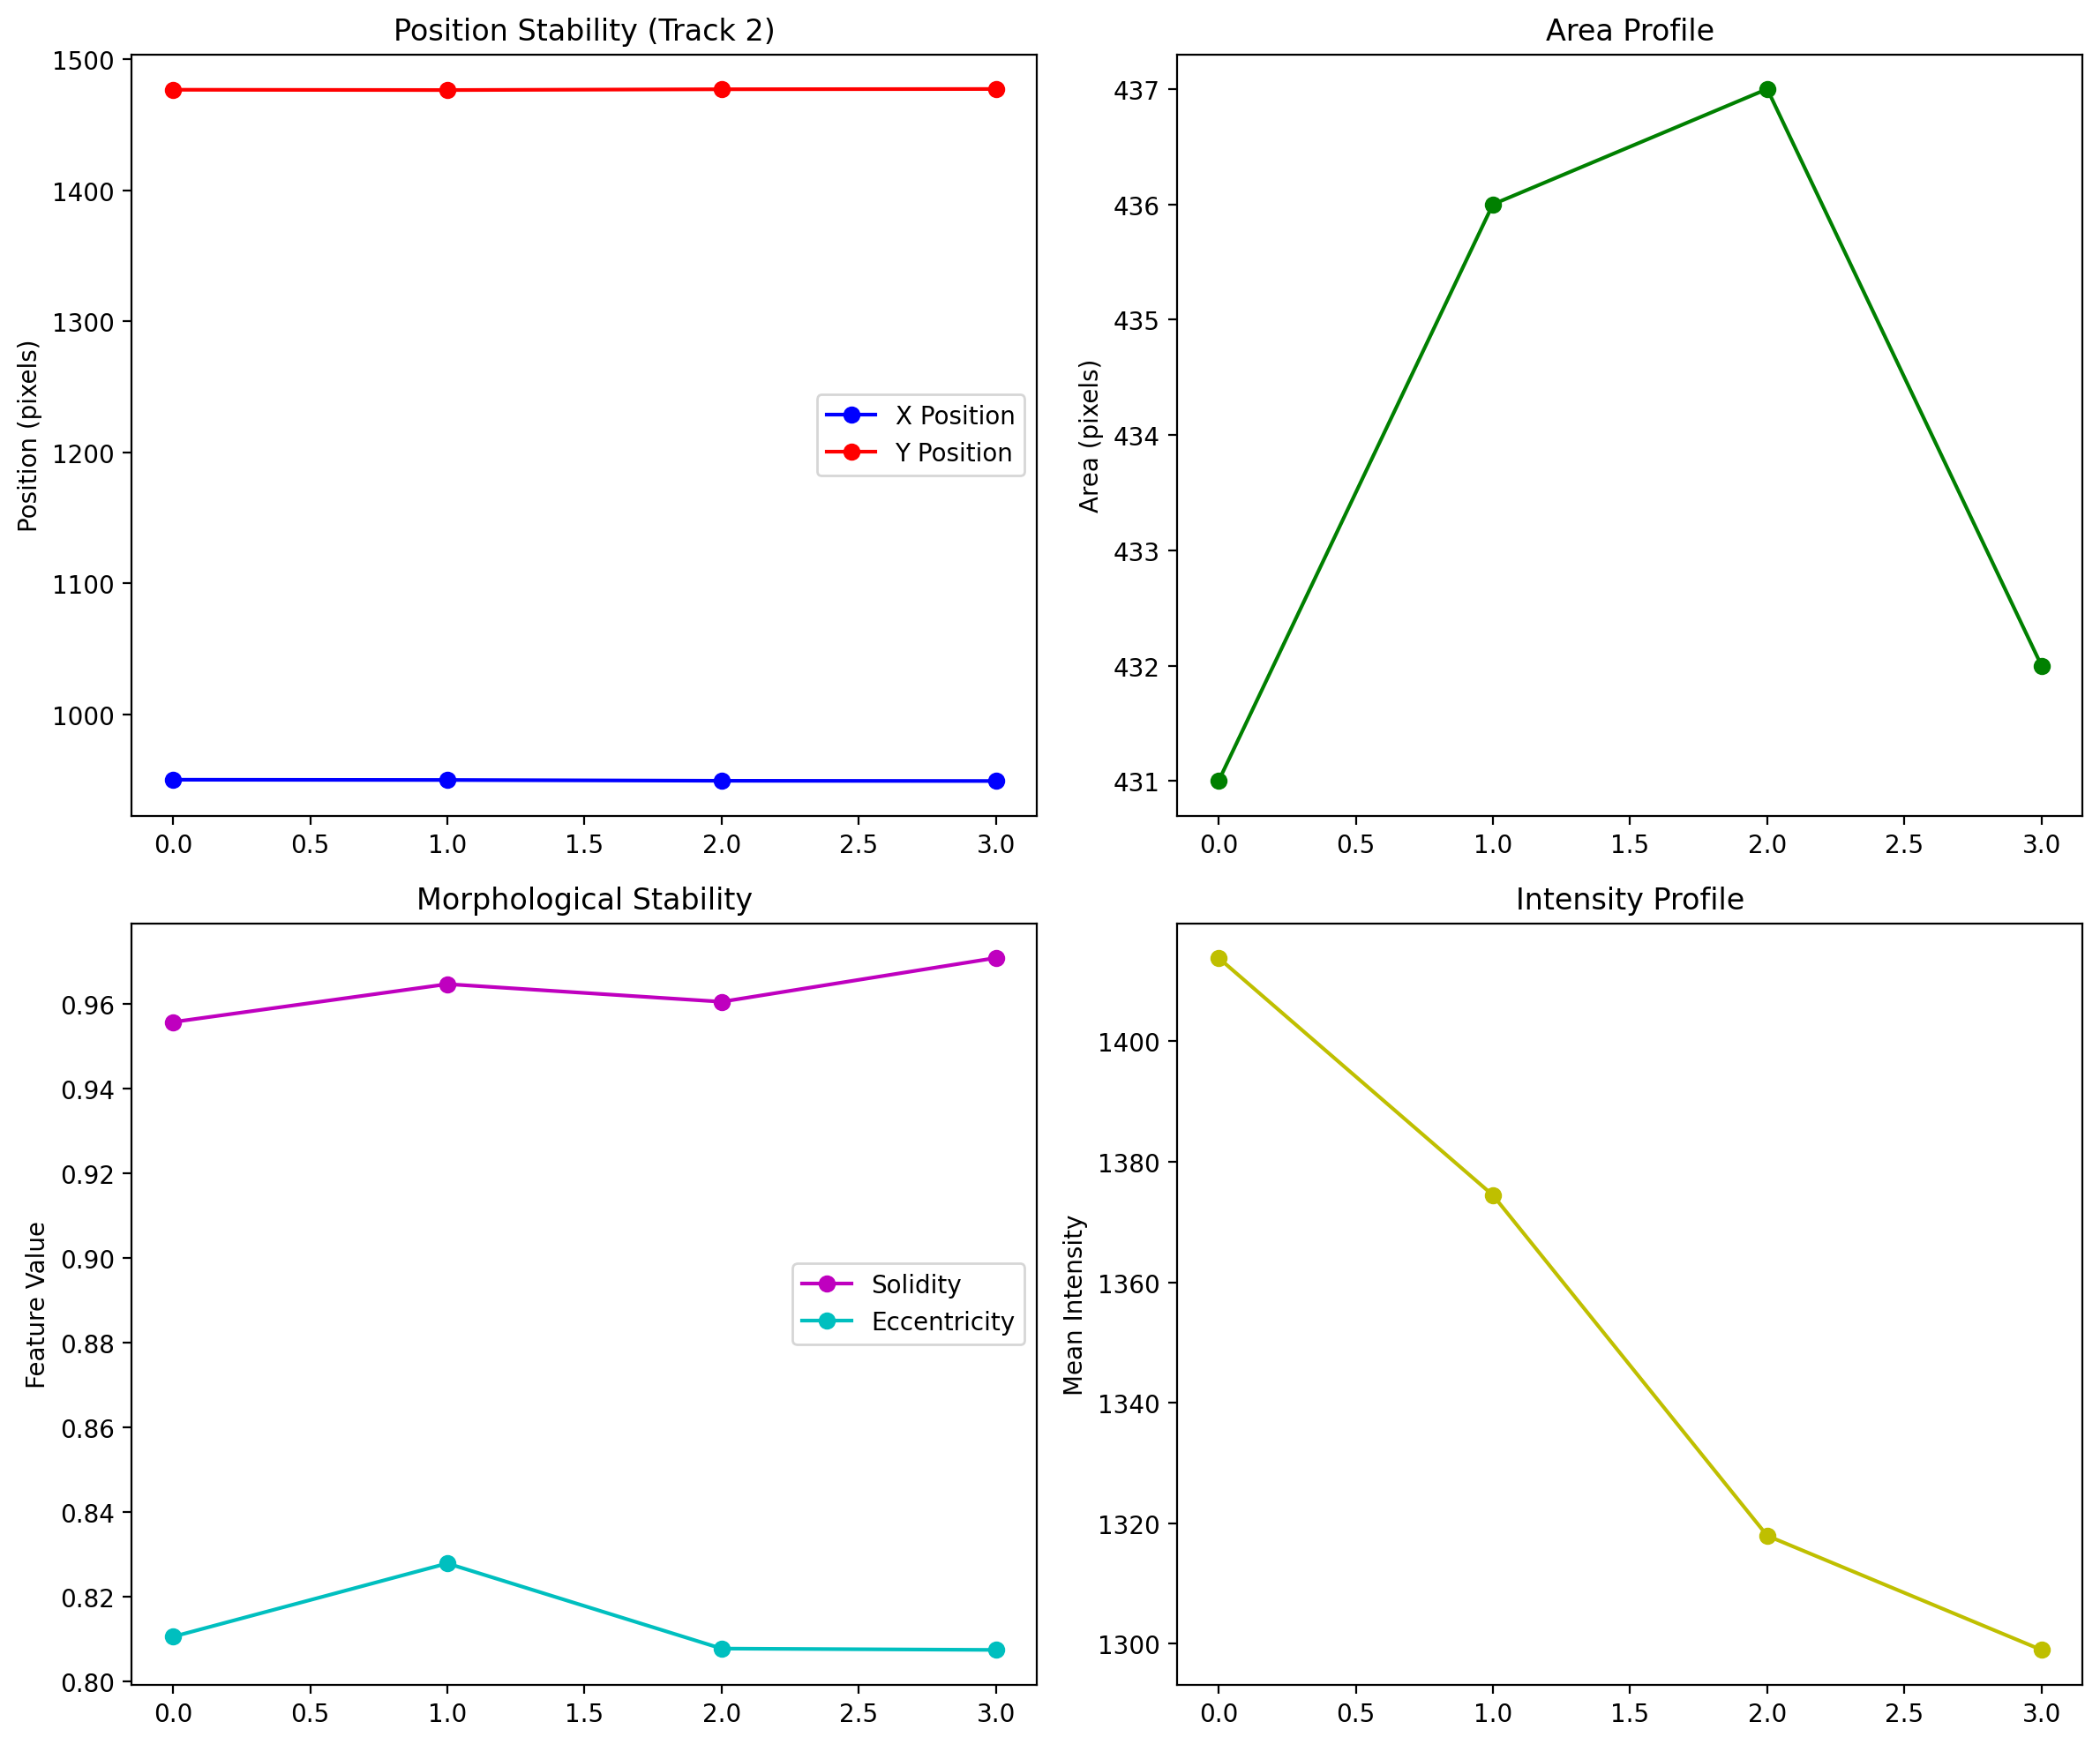

In [65]:
valid_tracks = validate_cardiac_tracks(linked_df)

# Check results
print(f"Found {valid_tracks['particle'].nunique()} valid tracks")
print(f"{len(linked_df) - len(valid_tracks)} nuclei rejected")

# Plot validation results
if not valid_tracks.empty:
    sample_particle_id = valid_tracks['particle'].iloc[0]
    plot_track_diagnostics(sample_particle_id, df=valid_tracks)
else:
    print("No valid tracks found. Check filtering parameters.")

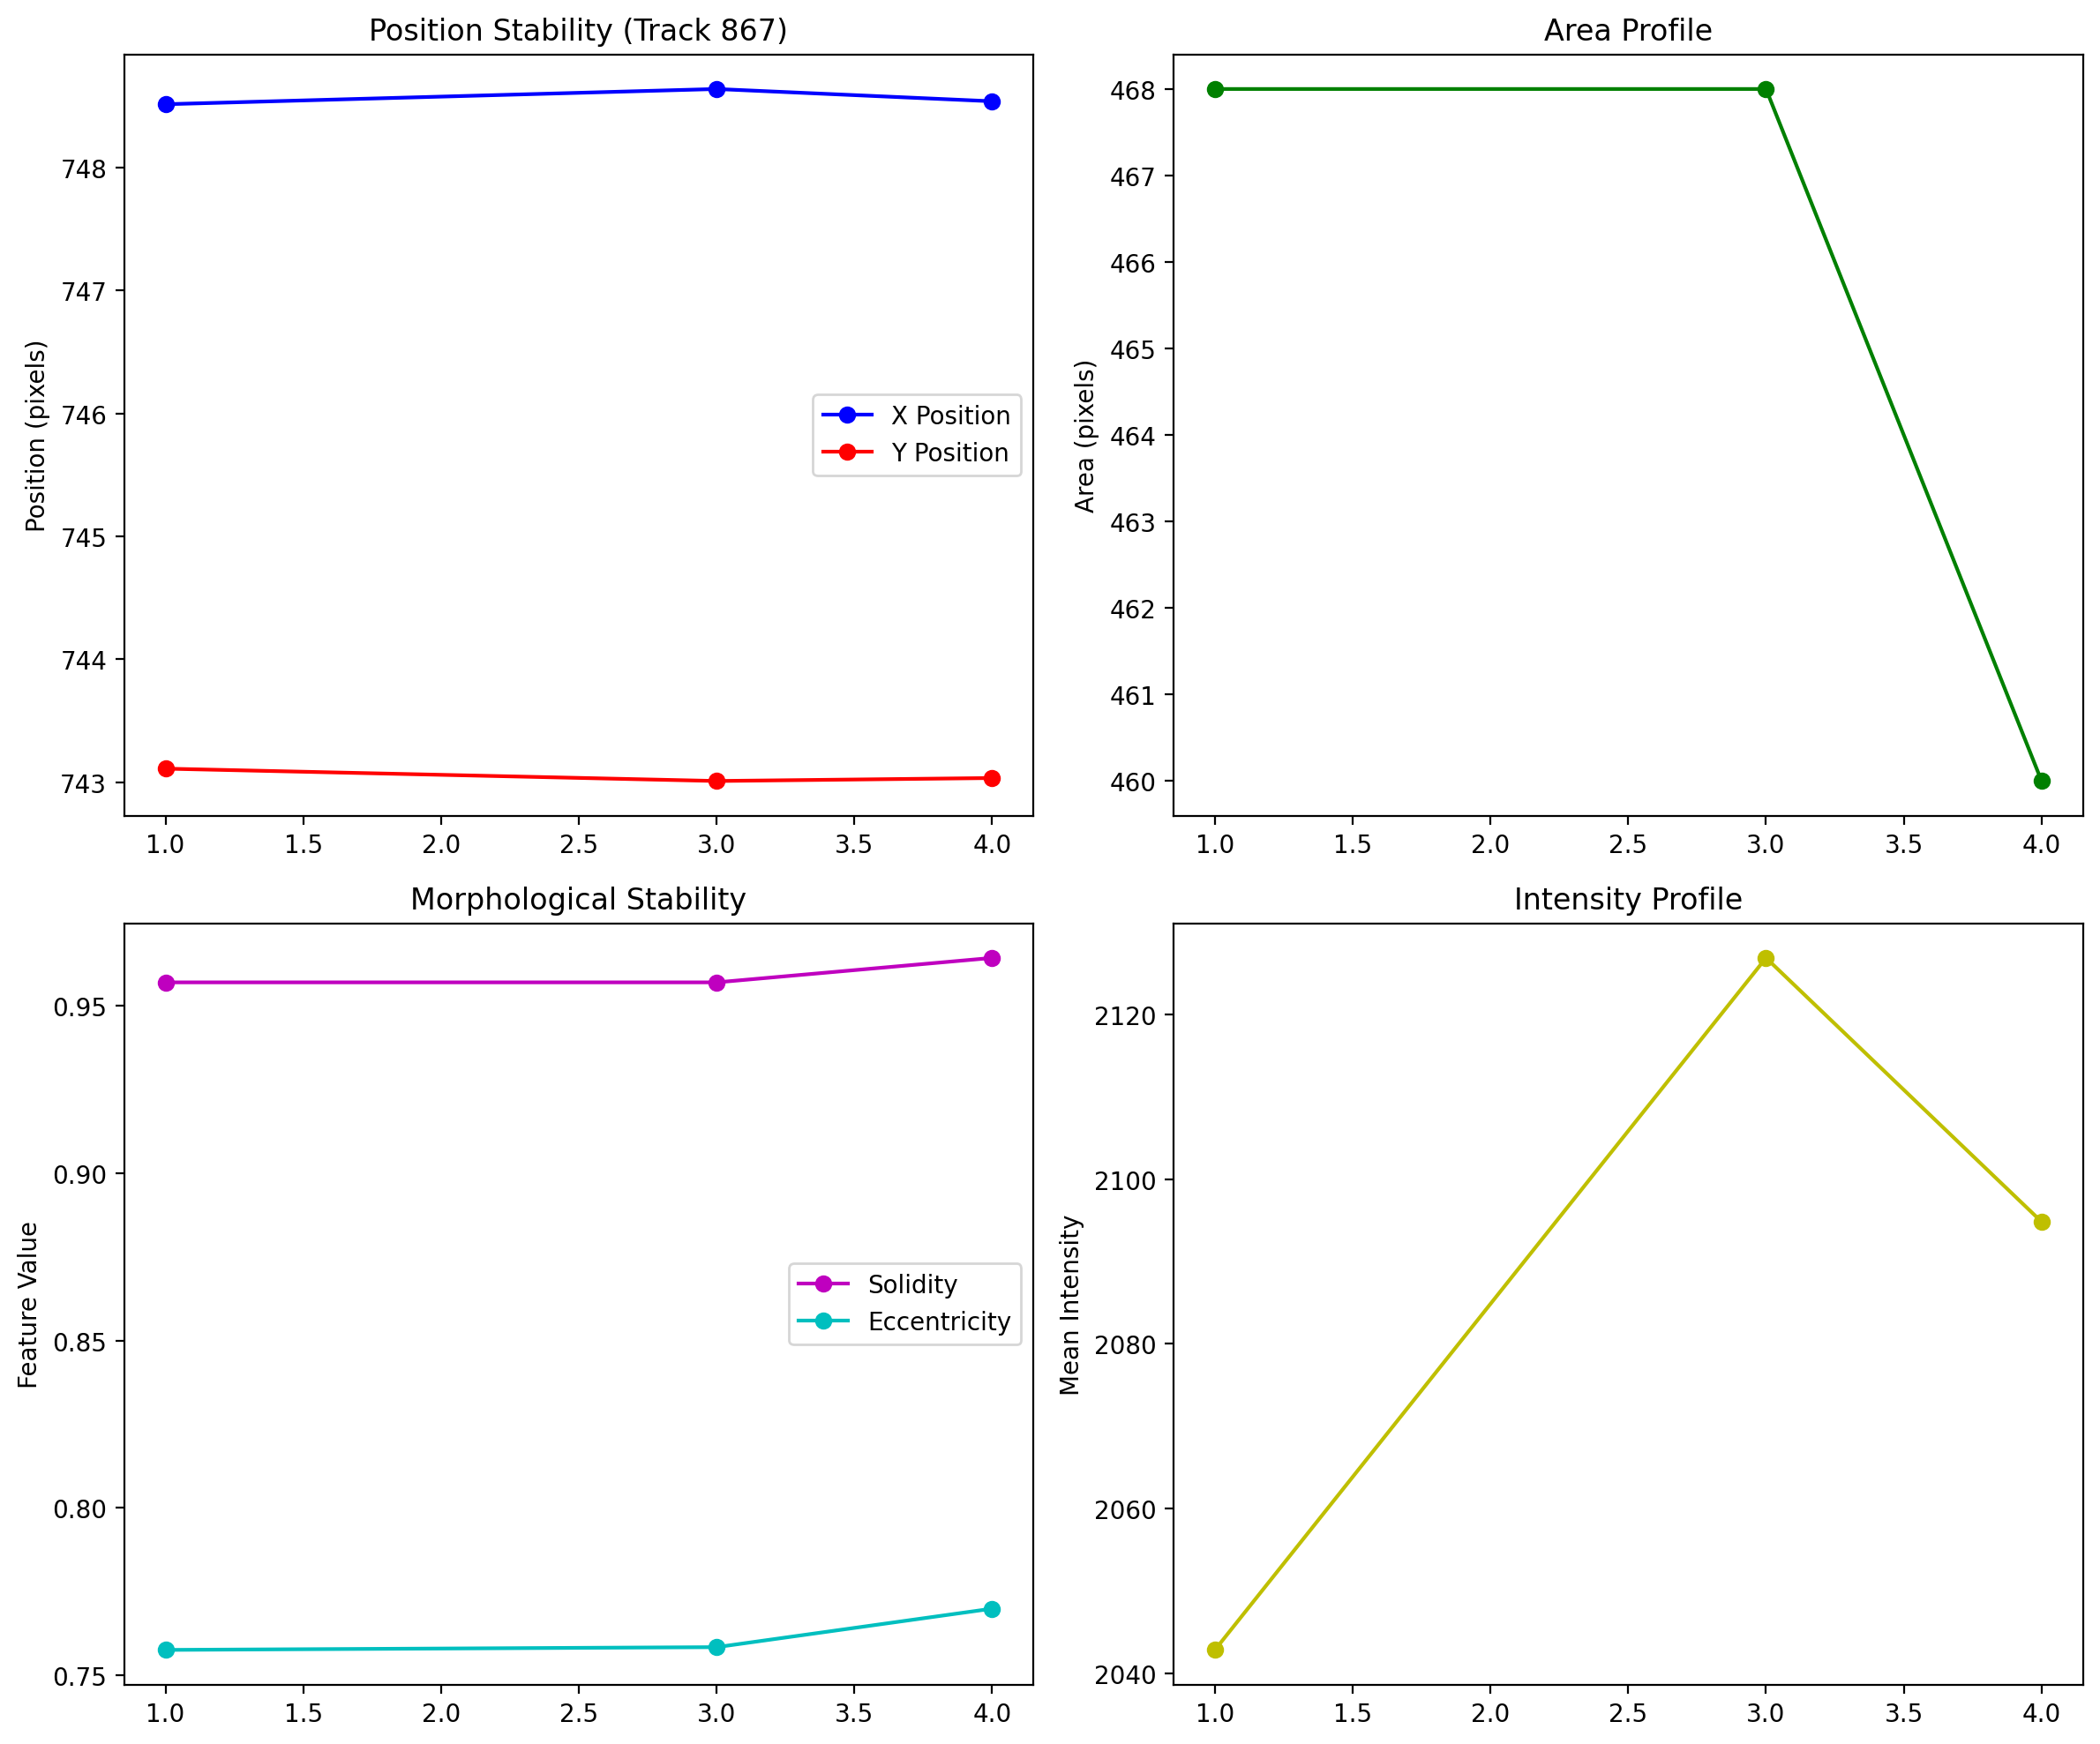

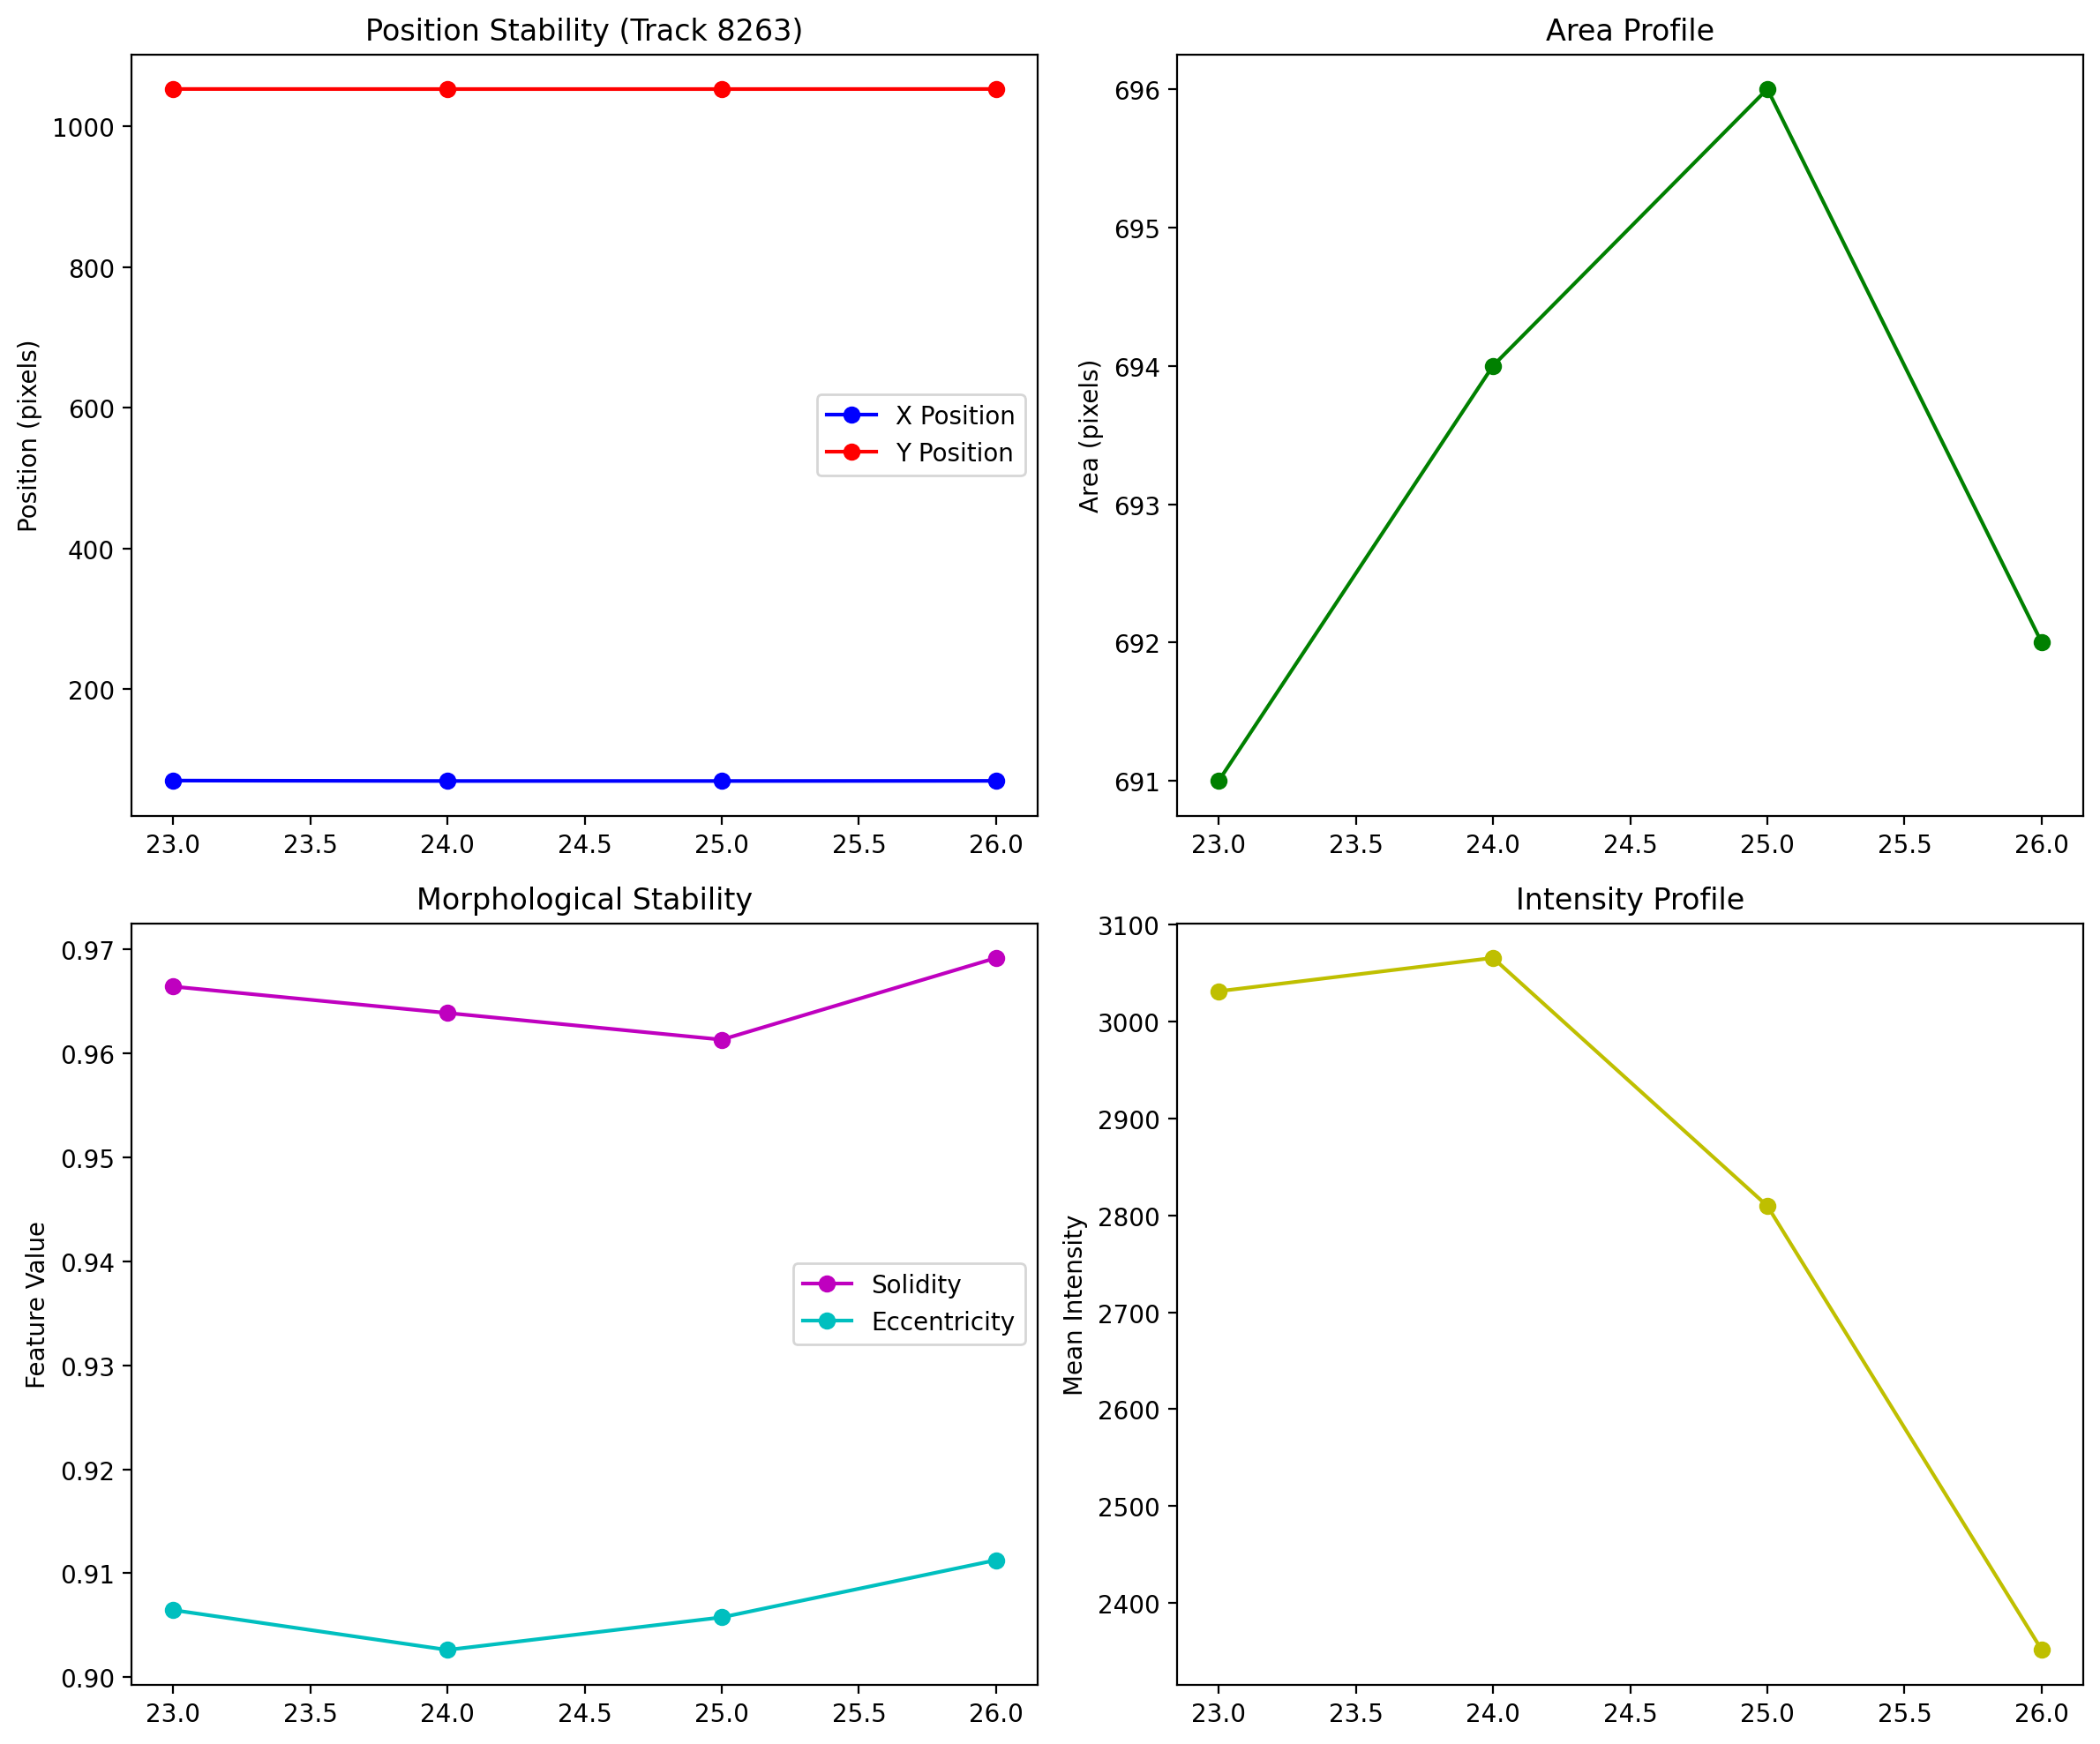

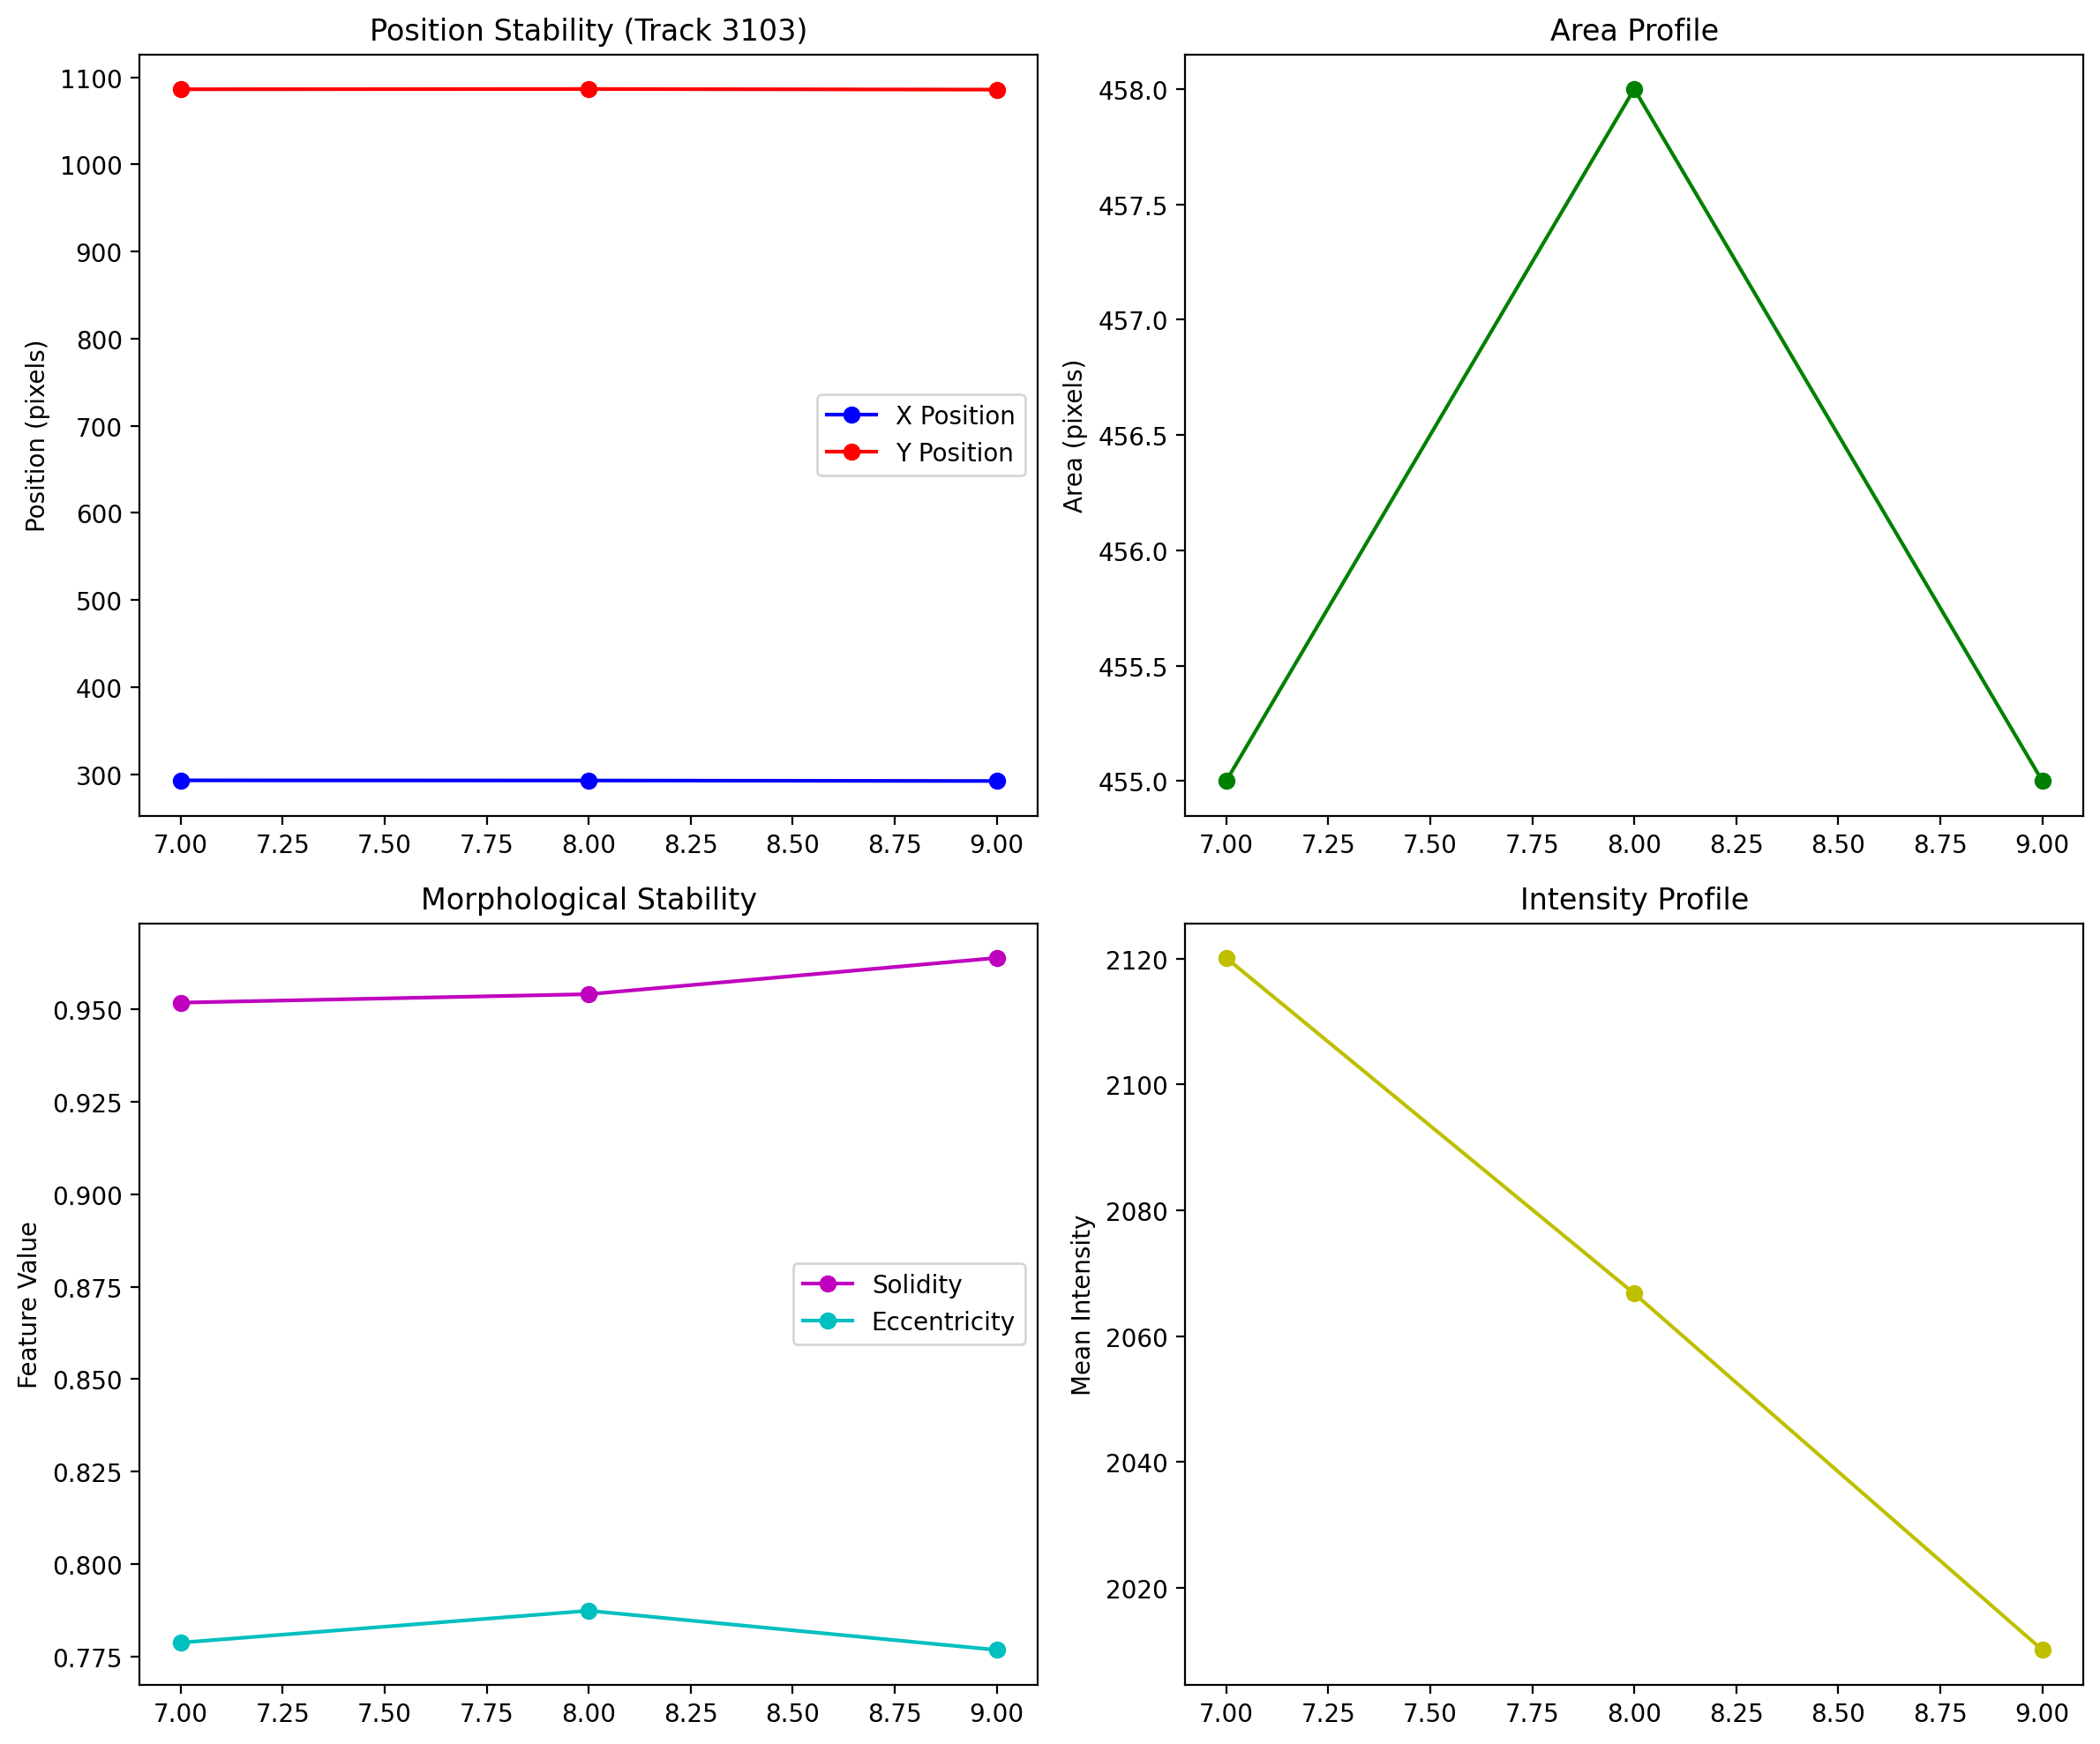

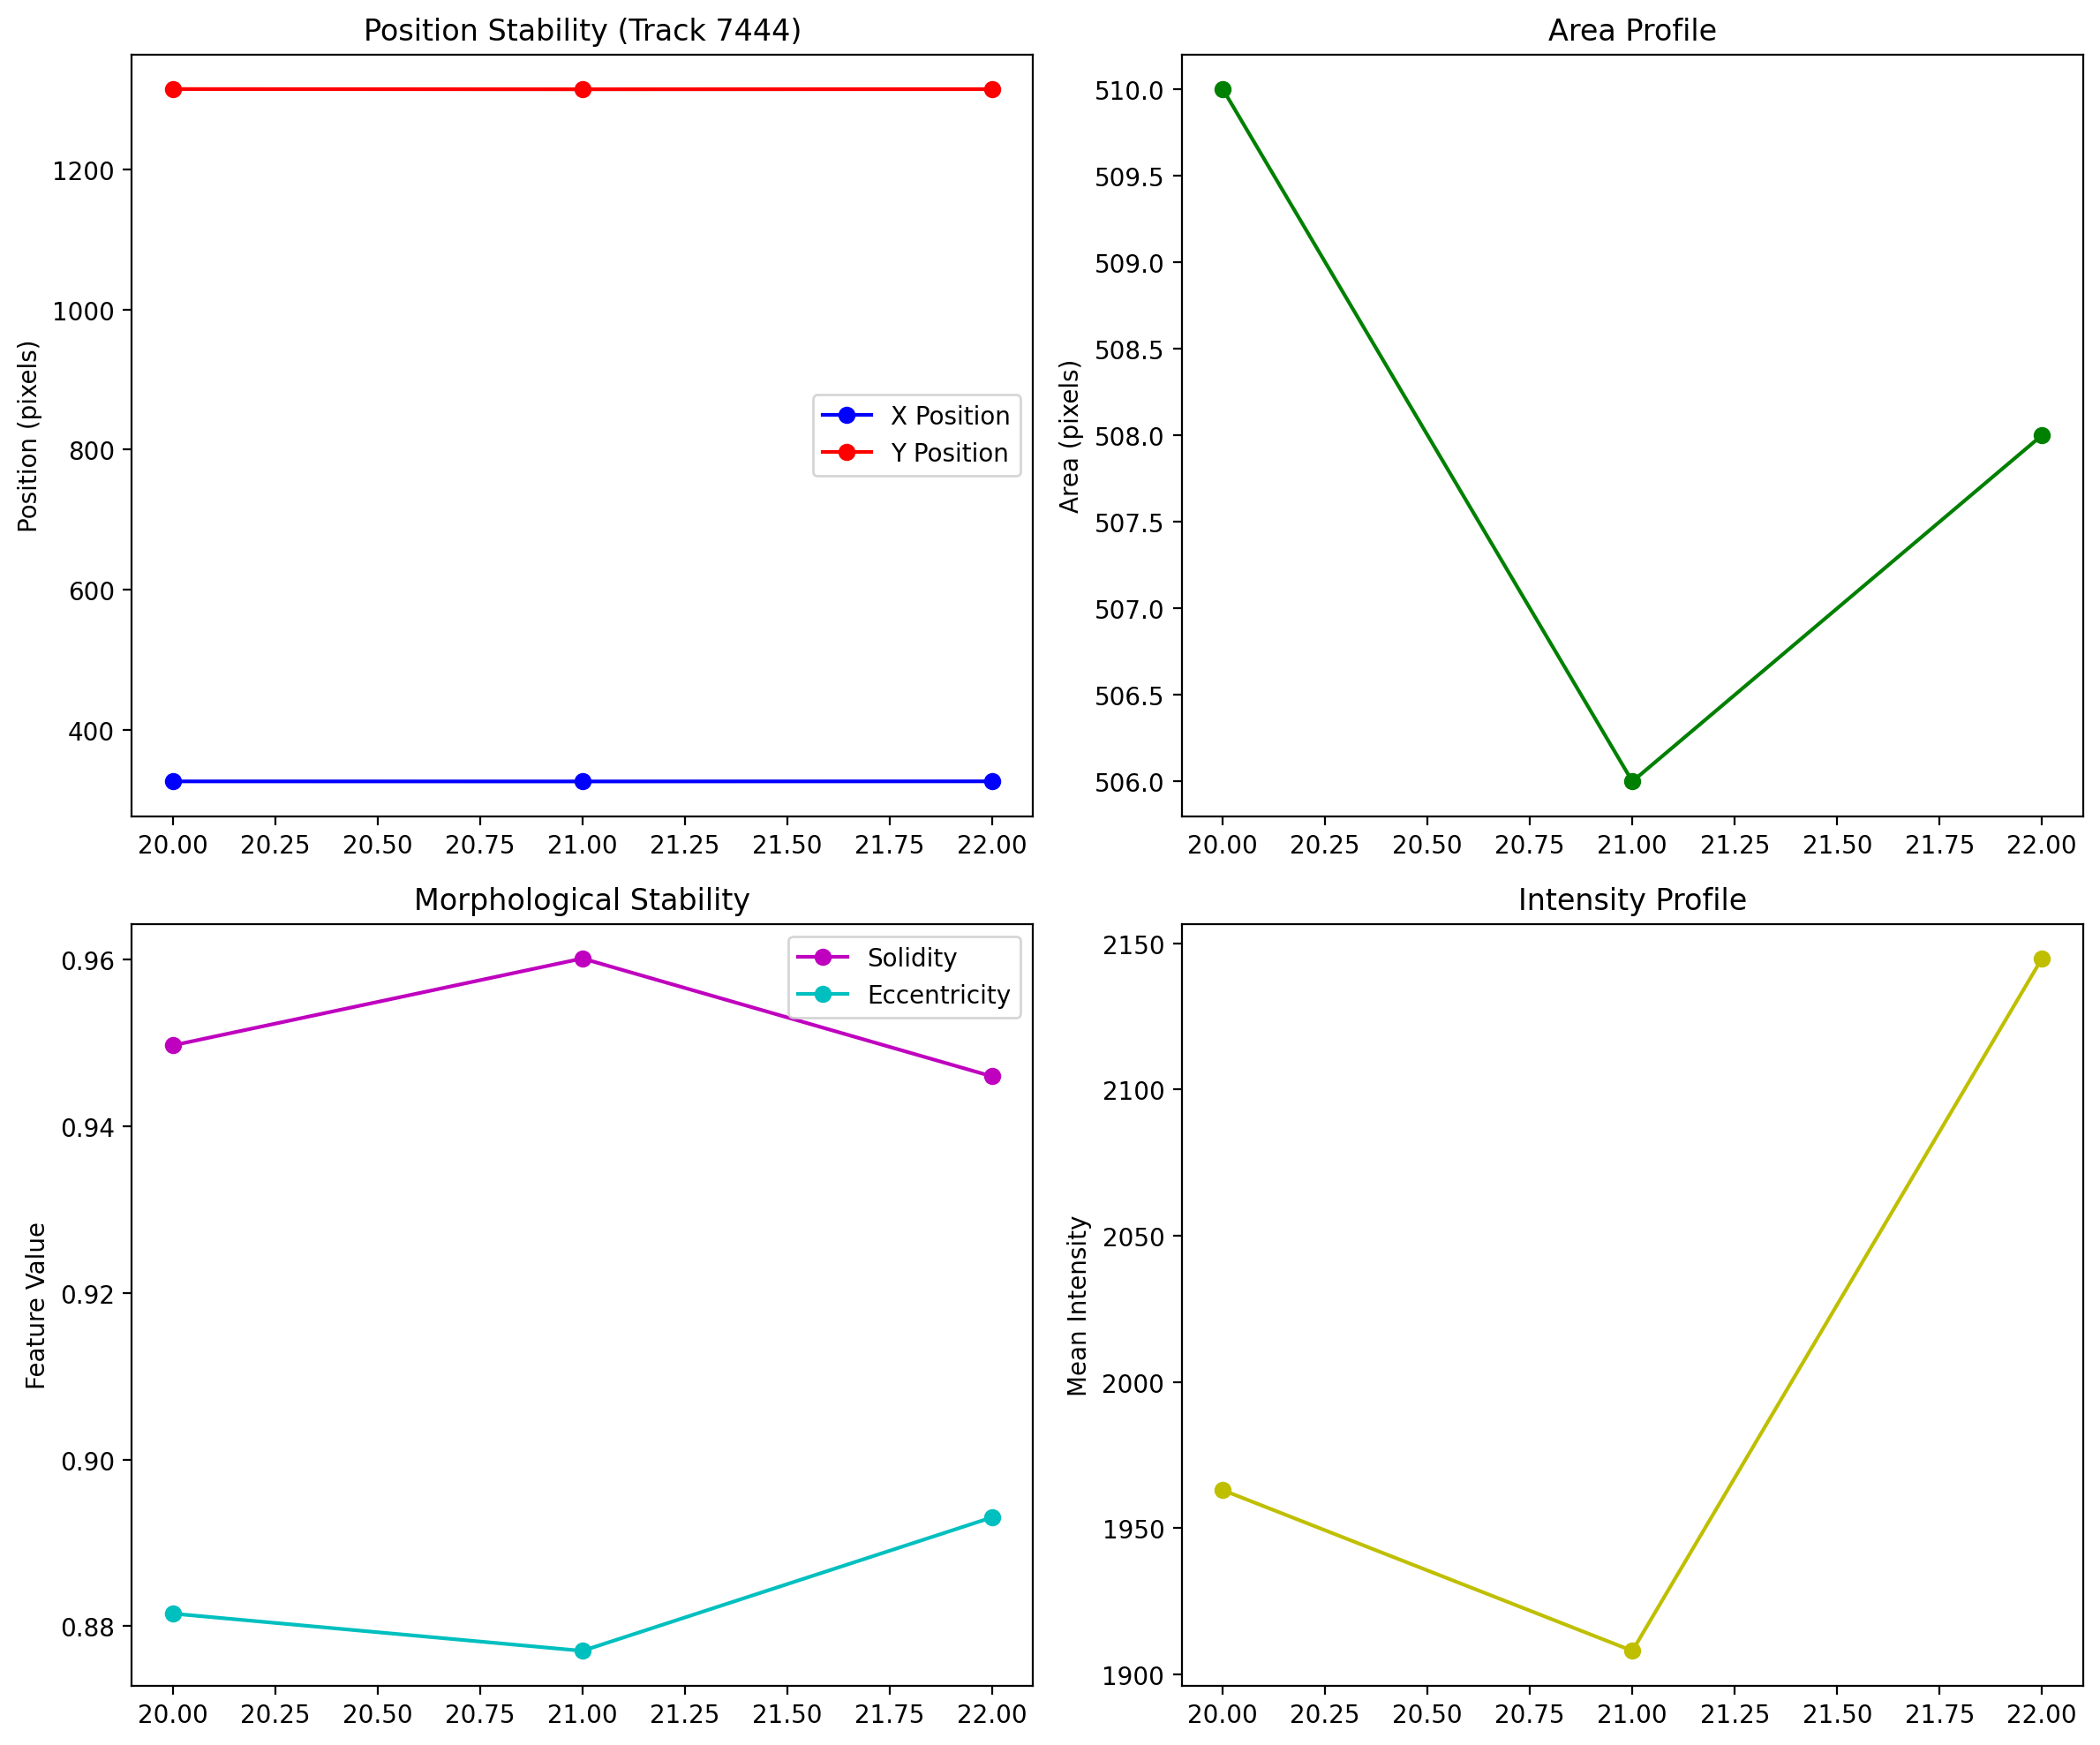

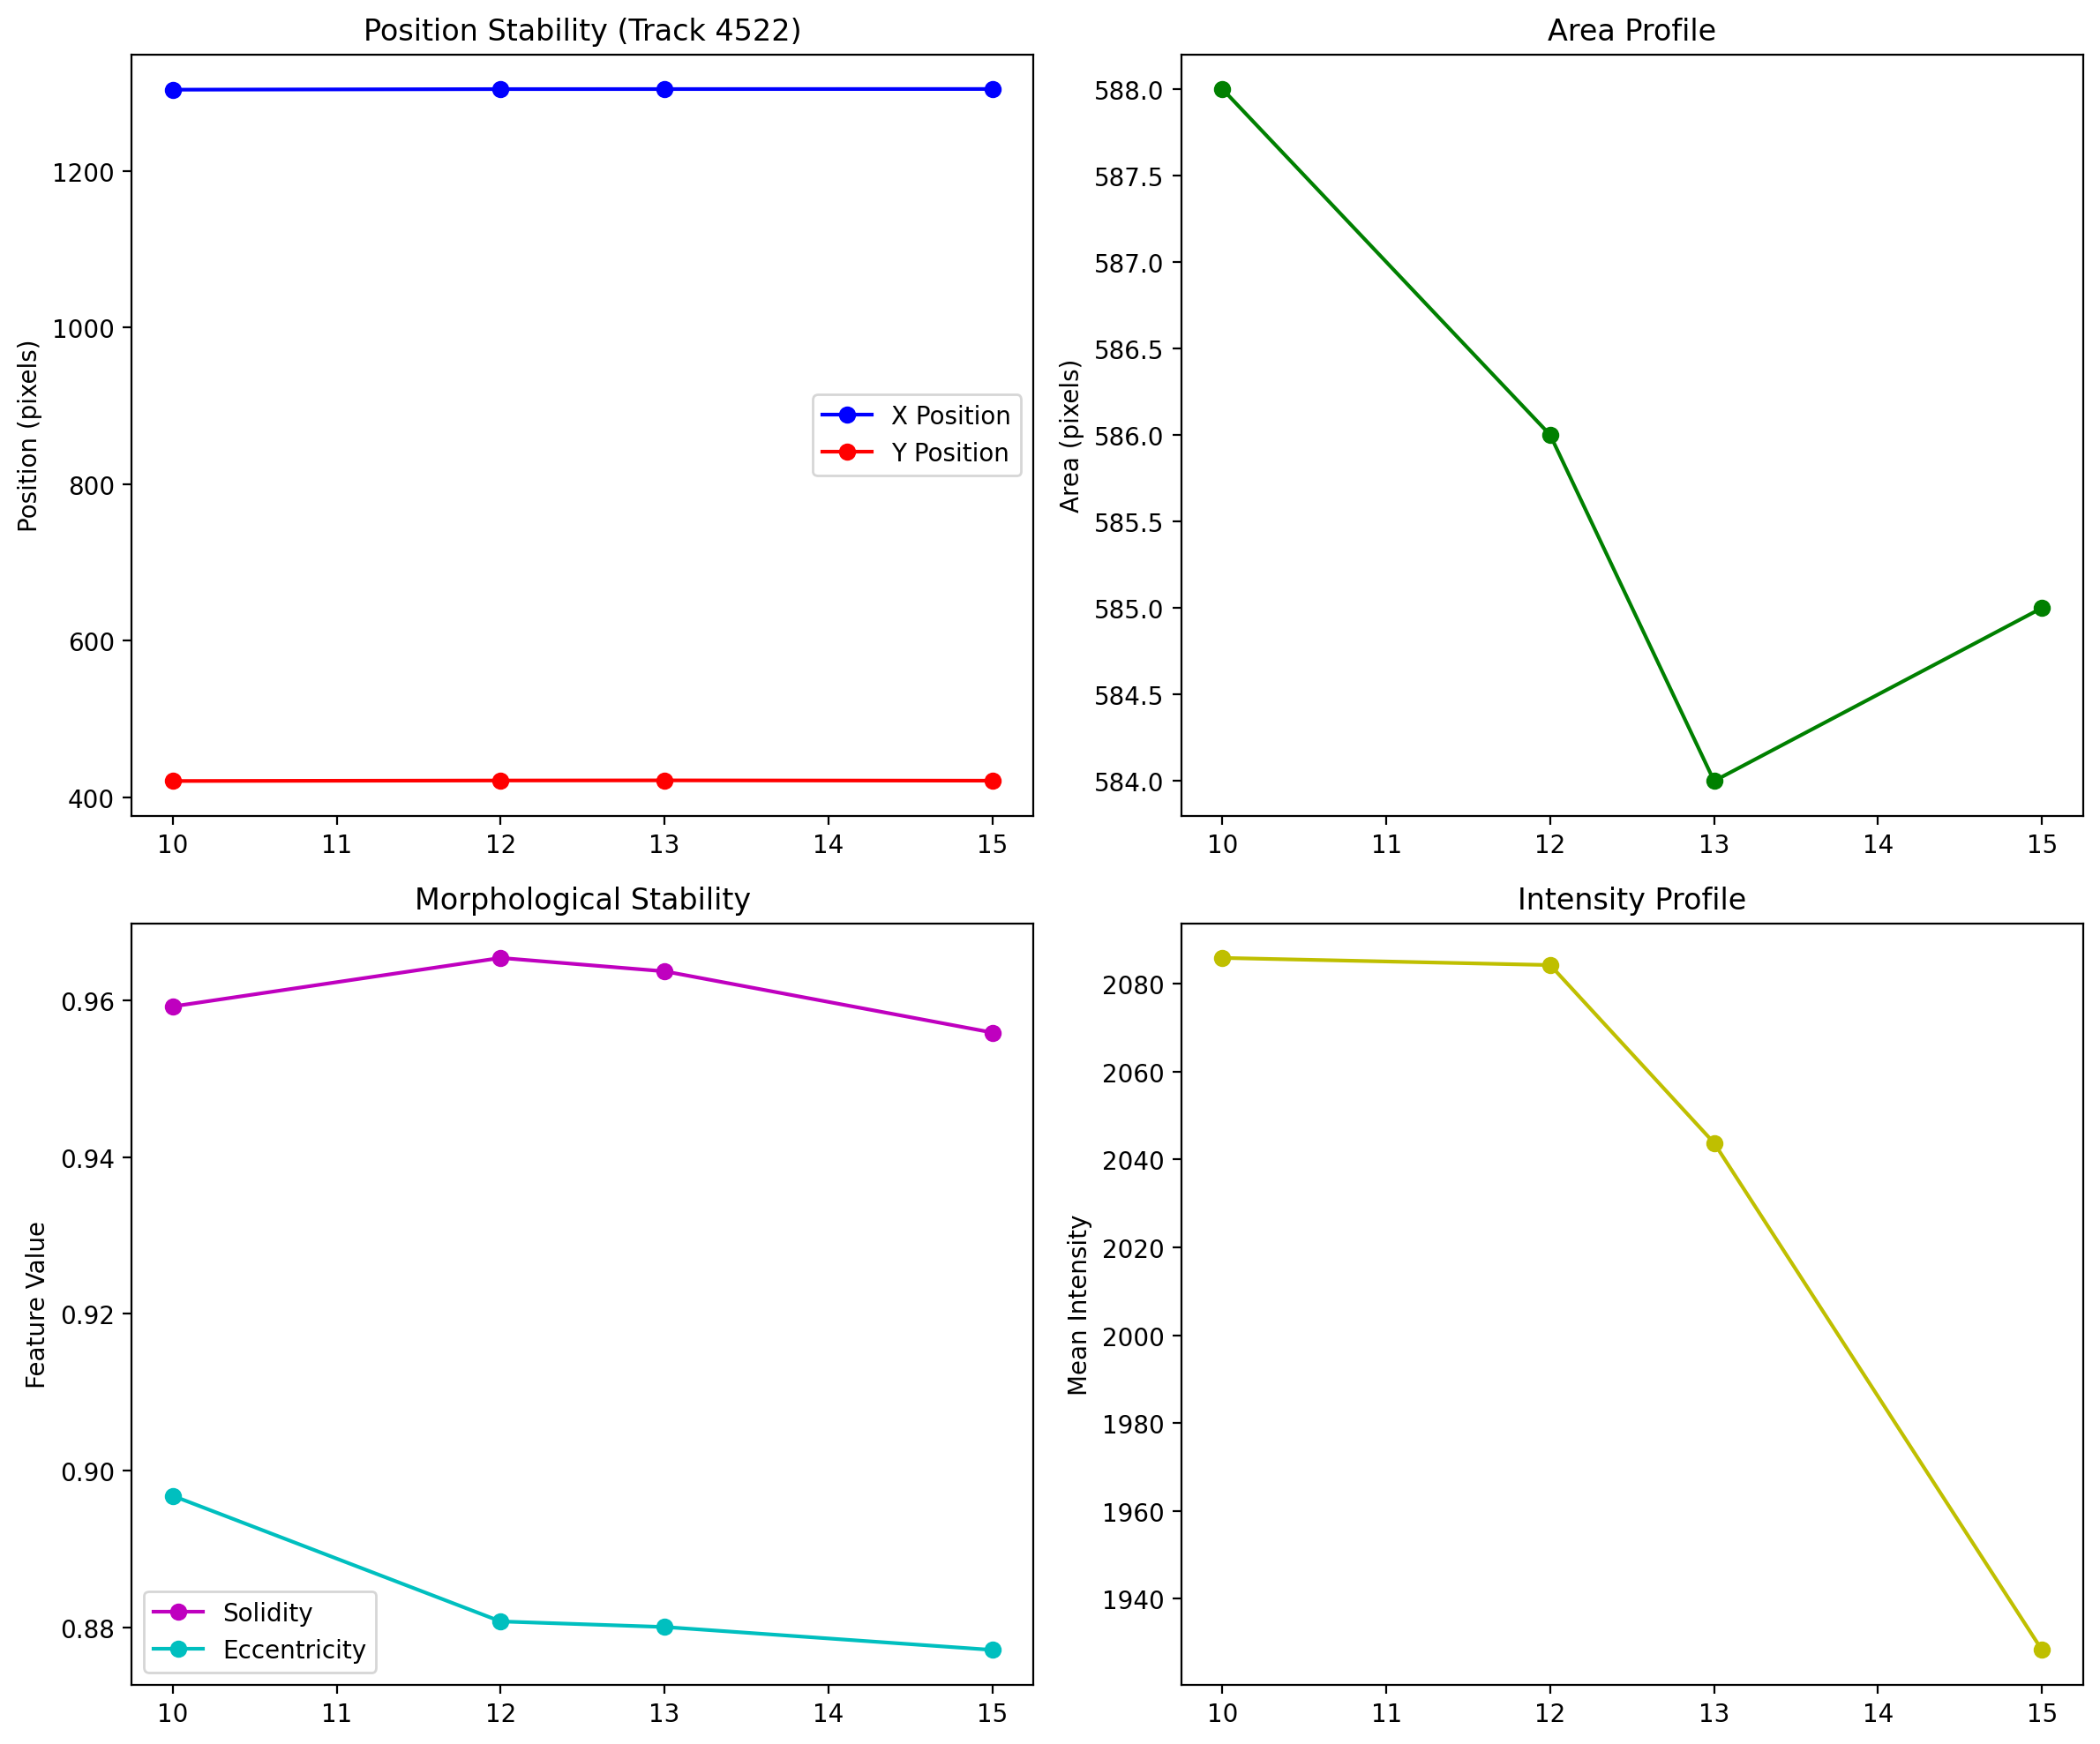

In [66]:
import numpy as np

# Choose 5 random particle IDs from the valid tracks
sample_ids = np.random.choice(valid_tracks['particle'].unique(), size=5, replace=False)

# Plot diagnostics for each
for pid in sample_ids:
    plot_track_diagnostics(particle_id=pid, df=valid_tracks)